In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import matplotlib as mpl
import mplhep
import sys

sys.path.append("../../../analysisTools/")
import plotTools as ptools

In [2]:
# Initialize some dictionary that will later be used
signal_df = {} # yield
signal_match_df = {} # gen matched vtx

signal_reco_df = {} # yield only counting the events where gen ee are reconstructed
signal_match_reco_df = {} # gen matched vtx, out of the events where gen ee are reconstructed

for delta in ['0p1','0p2']:
    signal_df[delta] = {}
    signal_match_df[delta] = {}
    signal_reco_df[delta] = {}
    signal_match_reco_df[delta] = {}

In [3]:
sqrtBs = {'1': 0, '10': 0, '100': 0}

In [4]:
def plot_efficiency_signal_varying_M1(df_sig, dict_eff, cuts, cutNames, delta, ct, ylim = [1e-5,5e-2], ylabel='Efficiency', doLegend=True, doLog=True, doSave=False, outDir = 'plots/cutflow/', outName='efficiency.png'):
    m1s = sorted(list(set(df_sig[(df_sig.delta==delta)&(df_sig.ctau==ct)].m1)))
        
    for m1 in m1s:
        pt = df_sig[(df_sig.delta==delta) & (df_sig.m1==m1) & (df_sig.ctau==ct)].name[0]
        effs = [dict_eff[pt][cut] for cut in cuts]
        plt.plot(np.arange(len(cuts)), effs, label=r"$M_1 = {0}$ GeV".format(m1), color=f"C{m1s.index(m1)}")

    if doLog:
        plt.yscale('log')

    plt.ylabel(ylabel)
    
    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

    plt.grid()

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    plt.ylim(ylim)
    
    if doLegend:
        plt.legend()
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

In [5]:
def plot_counts_signal_varying_M1(df_sig, dict_eff, cuts, cutNames, delta, ct, ylabel='Events', doLegend=True, doLog=True, doSave=False, outDir = 'plots/cutflow/', outName='efficiency.png'):
    m1s = sorted(list(set(df_sig[(df_sig.delta==delta)&(df_sig.ctau==ct)].m1)))
        
    for m1 in m1s:
        pt = df_sig[(df_sig.delta==delta) & (df_sig.m1==m1) & (df_sig.ctau==ct)].name[0]
        effs = [dict_eff[pt][cut] for cut in cuts]
        plt.plot(np.arange(len(cuts)), effs, label=r"$M_1 = {0}$ GeV".format(m1), color=f"C{m1s.index(m1)}")

    if doLog:
        plt.yscale('log')

    plt.ylabel(ylabel)
    
    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

    plt.grid()

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    if doLegend:
        plt.legend()
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

## Ctau-1

### Import coffea files -- signal and background

In [6]:
prefix = './coffea/skimmed/'
suffix = '_SR_BDTv2_ctau-1_5to50_skimmed'

In [7]:
# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

In [8]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

### Cutflow Dataframe -- signal

In [9]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

In [10]:
# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

In [11]:
# signal efficiencies, when only looking at the events where the gen ee are reconstructed (dR(gen,reco) < 0.1)
cf_s_reco = sig_histo['cutflow_genEEreconstructed']              # efficiency
ct_s_reco = sig_histo['cutflow_cts_genEEreconstructed']          # xsec-weighted event count
fr_s_reco = sig_histo['cutflow_vtx_matched_genEEreconstructed']  # fraction that selected vtx is truth-matched, for signal

In [12]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}

In [13]:
deltas = sorted(list(set(si.delta)))

#### For signal events

In [14]:
sig_columns = list(cf_s.keys())
sig_efficiency = {c: [ cf_s[samp][c] for samp in sig_columns ] for c in cuts}
sig_match = {c: [ fr_s[samp][c] for samp in sig_columns ] for c in cuts}

In [15]:
sig_eff_df = pd.DataFrame.from_dict(sig_efficiency).transpose()
sig_eff_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_df.index = cut

In [16]:
sig_eff_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,0.033826,0.009426,0.007917,0.007607,0.007607,0.003959,0.003736,0.001603
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,0.014782,0.003136,0.002708,0.002563,0.002563,0.001346,0.001271,0.000415
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,0.014484,0.002886,0.002380,0.002244,0.002240,0.001129,0.001074,0.000330
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,0.036445,0.008902,0.007712,0.007403,0.007403,0.003622,0.003461,0.001185
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,0.020878,0.005298,0.004643,0.004471,0.004463,0.002238,0.002136,0.000900
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,0.030396,0.007135,0.006127,0.005856,0.005850,0.002725,0.002609,0.000943
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,0.023214,0.005053,0.004338,0.004171,0.004171,0.002089,0.002010,0.000660
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,0.016920,0.004024,0.003437,0.003258,0.003258,0.001640,0.001556,0.000632
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,0.018942,0.004017,0.003370,0.003222,0.003220,0.001627,0.001577,0.000533
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,0.014729,0.003148,0.002666,0.002542,0.002542,0.001282,0.001206,0.000446


In [17]:
sig_counts = {c: [ ct_s[samp][c] for samp in sig_columns ] for c in cuts}

In [18]:
sig_cts_df = pd.DataFrame.from_dict(sig_counts).transpose()
sig_cts_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_df.index = cut

In [19]:
sig_cts_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,205.186408,57.180353,48.025582,46.142725,46.142725,24.016270,22.665339,9.722081
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,62382.758208,13235.666814,11429.745437,10816.275511,10816.275511,5680.202940,5364.884123,1753.241080
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,2748.241352,547.622429,451.519079,425.744664,425.099182,214.196450,203.874319,62.608122
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,6585.302053,1608.579945,1393.447034,1337.607026,1337.607026,654.384098,625.407614,214.119277
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,49723.242758,12618.624967,11057.113236,10647.756161,10629.961878,5331.029271,5087.532235,2143.166005
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,16108.593245,3781.029007,3246.954592,3103.225149,3100.492714,1444.161464,1382.532408,499.574489
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,33794.913061,7356.157096,6314.429388,6072.366651,6072.366651,3040.907483,2926.767574,960.999523
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,995.446867,236.713320,202.210754,191.695909,191.695909,96.476888,91.569346,37.158979
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,30374.505276,6441.605298,5403.497955,5166.743169,5163.208983,2609.571496,2528.260783,854.407333
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,1394.264143,298.008932,252.364528,240.632015,240.632015,121.382782,114.124832,42.245148


In [20]:
sig_match_df = pd.DataFrame.from_dict(sig_match).transpose()
sig_match_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_df.index = cut

In [21]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,1.0,0.443749,0.460946,0.468083,0.468083,0.483621,0.476615,0.972150
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1.0,0.300678,0.315971,0.320920,0.320920,0.339532,0.339876,0.989982
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,1.0,0.319274,0.330082,0.331896,0.332400,0.307354,0.313439,0.958770
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,1.0,0.369781,0.376774,0.379370,0.379370,0.370696,0.372165,0.963769
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,1.0,0.422382,0.422431,0.421959,0.422108,0.406476,0.410735,0.939029
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1.0,0.350106,0.355382,0.355087,0.354959,0.371525,0.379165,0.972594
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1.0,0.326664,0.325187,0.325959,0.325959,0.327085,0.328354,0.947565
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,1.0,0.389765,0.400093,0.397183,0.397183,0.401140,0.398145,0.962294
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1.0,0.336599,0.336555,0.340356,0.339904,0.331503,0.332356,0.958670
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,1.0,0.330039,0.341581,0.341388,0.341388,0.355089,0.360826,0.969700


#### For signal events having gen ee reconstructed (having reco e with dR < 0.1)

In [22]:
sig_columns_reco = list(cf_s_reco.keys())
sig_efficiency_reco = {c: [ cf_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}
sig_match_reco = {c: [ fr_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [23]:
sig_eff_reco_df = pd.DataFrame.from_dict(sig_efficiency_reco).transpose()
sig_eff_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_reco_df.index = cut

In [24]:
sig_eff_reco_df

,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-10p5_dMchi-1p0_ctau-1
Preselections,0.018895,0.005871,0.007196,0.017199,0.010975,0.014118,0.010520,0.008736,0.008445,0.007452,0.006857
0 < n(jet) < 3 & n(good vertex) > 0,0.006584,0.001707,0.001690,0.005296,0.003531,0.004071,0.002860,0.002567,0.002317,0.001927,0.001906
No b-tagged jets,0.005696,0.001491,0.001424,0.004640,0.003082,0.003541,0.002481,0.002233,0.001949,0.001659,0.001611
Leading jet |eta| < 2.4,0.005518,0.001441,0.001360,0.004489,0.002973,0.003412,0.002401,0.002116,0.001896,0.001584,0.001514
Leading jet pT > 80 GeV,0.005518,0.001441,0.001360,0.004489,0.002968,0.003407,0.002401,0.002116,0.001894,0.001584,0.001514
"dPhi(MET,leading jet) > 1.5",0.002982,0.000769,0.000687,0.002158,0.001493,0.001640,0.001202,0.001096,0.000936,0.000820,0.000783
"dPhi(MET,all jets) > 0.75",0.002849,0.000735,0.000670,0.002055,0.001433,0.001583,0.001161,0.001039,0.000909,0.000778,0.000766
BDT v2 Loose WP,0.001603,0.000415,0.000323,0.001174,0.000870,0.000935,0.000653,0.000632,0.000524,0.000446,0.000427


In [25]:
sig_counts_reco = {c: [ ct_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [26]:
sig_cts_reco_df = pd.DataFrame.from_dict(sig_counts_reco).transpose()
sig_cts_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_reco_df.index = cut

In [27]:
sig_cts_reco_df

,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-10p5_dMchi-1p0_ctau-1
Preselections,114.614464,24776.055248,1365.476804,3107.722465,26139.127171,7482.241053,15314.917103,513.957969,13541.062373,705.454678,16958.967758
0 < n(jet) < 3 & n(good vertex) > 0,39.938086,7205.591202,320.591914,956.846801,8409.758436,2157.411739,4163.532128,151.016756,3715.082204,182.397293,4714.580088
No b-tagged jets,34.551006,6293.661037,270.279248,838.460064,7341.025833,1876.583958,3612.288434,131.383074,3125.321970,157.021327,3984.140424
Leading jet |eta| < 2.4,33.472976,6083.110185,258.036813,811.070716,7080.051277,1808.174838,3494.586457,124.516029,3040.545119,149.981602,3744.240482
Leading jet pT > 80 GeV,33.472976,6083.110185,258.036813,811.070716,7068.180165,1805.442403,3494.586457,124.516029,3037.011200,149.981602,3744.240482
"dPhi(MET,leading jet) > 1.5",18.091176,3243.693610,130.330572,390.015888,3555.492238,869.176827,1750.486925,64.501634,1500.748287,77.662280,1936.038646
"dPhi(MET,all jets) > 0.75",17.279065,3103.450514,127.109378,371.388057,3412.879762,839.035661,1690.073333,61.135996,1458.270815,73.606873,1893.368937
BDT v2 Loose WP,9.722081,1753.241080,61.318683,212.055682,2071.878345,495.470809,950.905053,37.158979,840.281822,42.245148,1056.214305


In [28]:
sig_match_reco_df = pd.DataFrame.from_dict(sig_match_reco).transpose()
sig_match_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_reco_df.index = cut

In [29]:
sig_match_reco_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,1.0,0.635326,0.640711,0.645256,0.645256,0.642013,0.625187,0.972150
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1.0,0.552303,0.573826,0.570623,0.570623,0.594573,0.587539,0.989982
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,1.0,0.545371,0.551423,0.547607,0.547607,0.505133,0.502733,0.978932
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,1.0,0.621648,0.626166,0.625652,0.625652,0.621968,0.626716,0.973148
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,1.0,0.633774,0.636269,0.634589,0.634816,0.609461,0.612277,0.971339
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1.0,0.613588,0.614899,0.609407,0.609572,0.617300,0.624775,0.980649
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1.0,0.577153,0.568439,0.566403,0.566403,0.568206,0.568624,0.957624
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,1.0,0.610943,0.615780,0.611474,0.611474,0.599996,0.596340,0.962294
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1.0,0.583631,0.581884,0.578361,0.577870,0.576433,0.576218,0.974786
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,1.0,0.539233,0.548989,0.547727,0.547727,0.554989,0.559448,0.969700


In [30]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,1.0,0.443749,0.460946,0.468083,0.468083,0.483621,0.476615,0.972150
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1.0,0.300678,0.315971,0.320920,0.320920,0.339532,0.339876,0.989982
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,1.0,0.319274,0.330082,0.331896,0.332400,0.307354,0.313439,0.958770
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,1.0,0.369781,0.376774,0.379370,0.379370,0.370696,0.372165,0.963769
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,1.0,0.422382,0.422431,0.421959,0.422108,0.406476,0.410735,0.939029
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1.0,0.350106,0.355382,0.355087,0.354959,0.371525,0.379165,0.972594
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1.0,0.326664,0.325187,0.325959,0.325959,0.327085,0.328354,0.947565
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,1.0,0.389765,0.400093,0.397183,0.397183,0.401140,0.398145,0.962294
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1.0,0.336599,0.336555,0.340356,0.339904,0.331503,0.332356,0.958670
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,1.0,0.330039,0.341581,0.341388,0.341388,0.355089,0.360826,0.969700


### Cutflow Dataframe -- background

In [31]:
cuts = list(bkg_histos['W+jets']['cutflow']['bkg_2018_WJetsLNu_HT2500toInf'])

In [32]:
tot_bkg_cts = {} 
tot_bkg_effs = {} 
total_bkg_counts = {} 

In [33]:
for b in bkg_histos.keys():
    
    total_bkg_counts[b] = 0
    for k in bkg_histos[b]['cutflow'].keys():
        total_bkg_counts[b] += bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']

In [34]:
for b in bkg_histos.keys():
    cfd = bkg_histos[b]['cutflow_cts']
    effd = bkg_histos[b]['cutflow']

    cts_dict = {k:0 for k in cuts}
    
    for k in cfd.keys():
        for c in cuts:
            cts_dict[c] += cfd[k][c]

    tot_bkg_cts[b] = cts_dict # subprocess summed
    tot_bkg_effs[b] = {c:cts_dict[c]/total_bkg_counts[b] for c in cuts}

In [35]:
bkg_summed_cts = {c:sum([tot_bkg_cts[b][c] for b in tot_bkg_cts.keys()]) for c in cuts}

In [36]:
bkg_summed_eff = {c: bkg_summed_cts[c] / sum(total_bkg_counts.values()) for c in cuts}

In [37]:
bkg_columns = list(bkg_histos.keys())
bkg_columns.append('total')

tot_bkg_effs['total'] = bkg_summed_eff
tot_bkg_cts['total'] = bkg_summed_cts

In [38]:
bkg_efficiency = {c: [ tot_bkg_effs[samp][c] for samp in bkg_columns ] for c in cuts}
bkg_counts = {c: [ tot_bkg_cts[samp][c] for samp in bkg_columns ] for c in cuts}

In [39]:
bkg_eff_df = pd.DataFrame.from_dict(bkg_efficiency).transpose()
bkg_eff_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_eff_df.index = cut

In [40]:
bkg_eff_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,1.765167e-06,0.000129,1.126054e-05,6.373026e-04,0.001933,2.309964e-03,6.645339e-03,1.878092e-05
0 < n(jet) < 3 & n(good vertex) > 0,1.367991e-07,0.000023,2.142595e-06,8.314492e-05,0.000268,3.211313e-04,7.430600e-04,2.380365e-06
No b-tagged jets,9.141417e-08,0.000014,1.956258e-06,6.151165e-05,0.000179,2.572087e-04,6.081179e-04,1.906242e-06
Leading jet |eta| < 2.4,8.988998e-08,0.000013,1.956258e-06,5.764339e-05,0.000166,2.440454e-04,5.783924e-04,1.816663e-06
Leading jet pT > 80 GeV,8.988998e-08,0.000013,1.956258e-06,5.705314e-05,0.000166,2.435975e-04,5.773879e-04,1.813567e-06
"dPhi(MET,leading jet) > 1.5",5.039459e-08,0.000007,4.101039e-07,2.834303e-05,0.000082,1.211213e-04,2.905525e-04,8.793299e-07
"dPhi(MET,all jets) > 0.75",1.448723e-08,0.000003,3.726753e-07,1.225552e-05,0.000025,6.645713e-05,1.782490e-04,4.942504e-07
BDT v2 Loose WP,0.000000e+00,0.000000,0.000000e+00,7.046273e-08,0.000000,1.742812e-07,1.778133e-07,9.317278e-10


In [41]:
bkg_cts_df = pd.DataFrame.from_dict(bkg_counts).transpose()
bkg_cts_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_cts_df.index = cut

In [42]:
bkg_cts_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,38039.826987,5667.491120,14495.724273,4424.202428,52.996922,227212.601036,142220.153499,432112.996264
0 < n(jet) < 3 & n(good vertex) > 0,2948.058507,987.165470,2758.167766,577.198283,7.343808,31587.113375,15902.592237,54767.639446
No b-tagged jets,1970.000354,624.570742,2518.294909,427.018510,4.918245,25299.553501,13014.629253,43858.985515
Leading jet |eta| < 2.4,1937.153597,554.510975,2518.294909,400.164705,4.565901,24004.791359,12378.460352,41797.941797
Leading jet pT > 80 GeV,1937.153597,552.935342,2518.294909,396.067158,4.549098,23960.729450,12356.962136,41726.691689
"dPhi(MET,leading jet) > 1.5",1086.017143,286.763600,527.927667,196.759431,2.237773,11913.733813,6218.256953,20231.696380
"dPhi(MET,all jets) > 0.75",312.203722,142.378761,479.745714,85.078707,0.698141,6536.855494,3814.794152,11371.754691
BDT v2 Loose WP,0.000000,0.000000,0.000000,0.489158,0.000000,17.142644,3.805469,21.437271


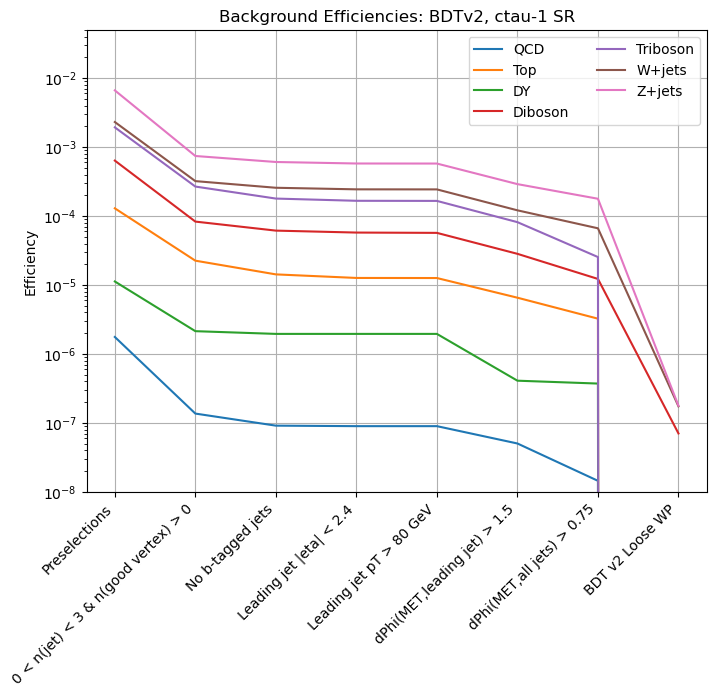

In [43]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title("Background Efficiencies: BDTv2, ctau-1 SR")

for b in bkg_histos.keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
#plt.savefig(f"plots/cutflows/bkg_combined_efficiencies.png")

### Bkg Yield

In [44]:
sqrtB = np.sqrt(bkg_cts_df.iloc[-1].loc['total'])

print('Total background after last SR cut: {:.2f}'.format(bkg_cts_df['total'].iloc[-1]))
print('sqrt(B) = {:.2f}'.format(sqrtB))

Total background after last SR cut: 21.44
sqrt(B) = 4.63


In [45]:
sqrtBs['1'] = sqrtB

### Signal Yield and Vtx Gen Matching Fraction

In [46]:
s_df = sig_cts_df.iloc[-1]
s_match_df = sig_match_df.iloc[-1]

# when only looking at the events where gen ee are reconstructed (dR(gen,reco)<0.1)
s_reco_df = sig_cts_reco_df.iloc[-1]
s_match_reco_df = sig_match_reco_df.iloc[-1]

In [47]:
columns_ctau = {'1': {'0p1': [], '0p2': []}, '10': {'0p1': [], '0p2': []}, '100': {'0p1': [], '0p2': []}}

for name in sig_columns:
    
    mchi = ptools.signalPoint(name)['mchi']
    dmchi = ptools.signalPoint(name)['dmchi']
    delta = ptools.signalPoint(name)['delta']

    if 'ctau-10' not in name:
        if delta == 0.1:
            columns_ctau['1']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['1']['0p2'].append(name)
    elif 'ctau-100' not in name:
        if delta == 0.1:
            columns_ctau['10']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['10']['0p2'].append(name)
    else:
        if delta == 0.1:
            columns_ctau['100']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['100']['0p2'].append(name)

ct = '1'
delta = '0p1'
print(columns_ctau[ct][delta])

['sig_2018_Mchi-5p25_dMchi-0p5_ctau-1', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-1', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-1', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-1', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-1']


In [48]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['1']:
        signal_df[delta][ctau] = s_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_df[delta][ctau].rename(index = {signal_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_df[delta][ctau] = s_match_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_df[delta][ctau].rename(index = {signal_match_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [49]:
print('Signal yield for delta = 0.1, ctau = 1')
signal_df['0p1']['1'].transpose()

Signal yield for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,1072.262222
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,854.407333
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,960.999523
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,499.574489
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,214.119277
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1753.241080


In [50]:
print('Vertex purity for delta = 0.1, ctau = 1')
signal_match_df['0p1']['1'].transpose()

Vertex purity for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,0.965175
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,0.958670
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,0.947565
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,0.972594
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,0.963769
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,0.989982


In [51]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['1']:
        signal_reco_df[delta][ctau] = s_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_reco_df[delta][ctau].rename(index = {signal_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_reco_df[delta][ctau] = s_match_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_reco_df[delta][ctau].rename(index = {signal_match_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [52]:
print('Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1')
signal_reco_df['0p1']['1'].transpose()

Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,1056.214305
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,840.281822
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,950.905053
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,495.470809
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,212.055682
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1753.241080


In [53]:
print('Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1')
signal_match_reco_df['0p1']['1'].transpose()

Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,0.979840
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,0.974786
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,0.957624
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,0.980649
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,0.973148
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,0.989982


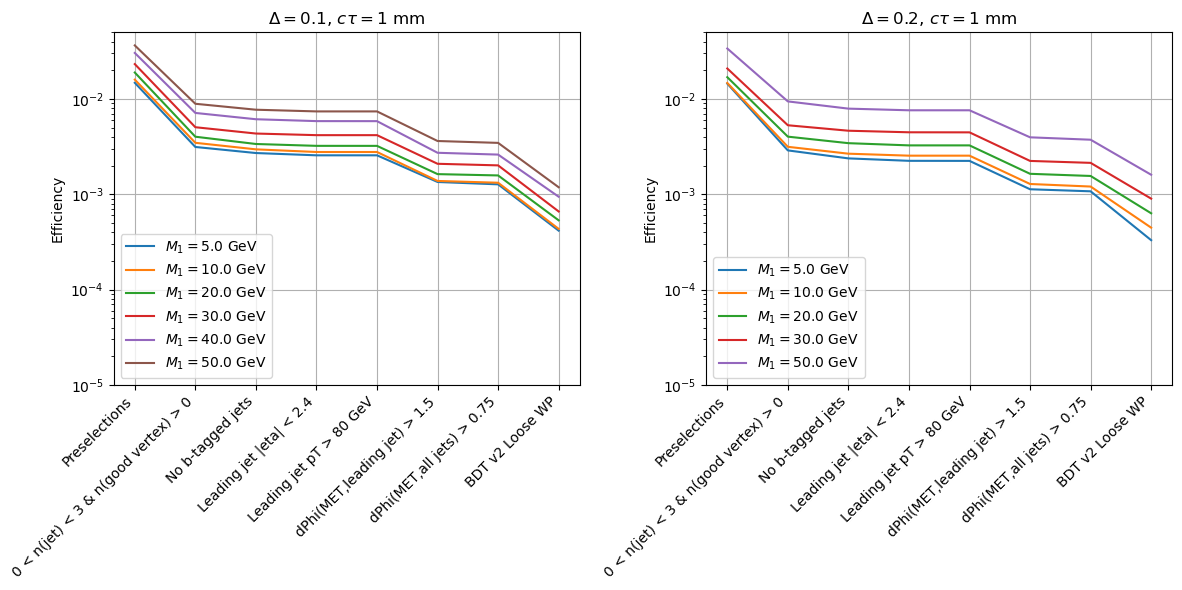

In [54]:
deltas = [0.1,0.2]

ct = 1

fig,axes = plt.subplots(1,len(deltas),figsize=(6*len(deltas),6))

for i, delta in enumerate(deltas):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

## Ctau-10

### Import coffea files -- signal and background

In [55]:
prefix = './coffea/skimmed/'
suffix = '_SR_BDTv2_ctau-10_5to50_skimmed'

In [56]:
# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

In [57]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

### Cutflow Dataframe -- signal

In [58]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

In [59]:
# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

In [60]:
# signal efficiencies, when only looking at the events where the gen ee are reconstructed (dR(gen,reco) < 0.1)
cf_s_reco = sig_histo['cutflow_genEEreconstructed']              # efficiency
ct_s_reco = sig_histo['cutflow_cts_genEEreconstructed']          # xsec-weighted event count
fr_s_reco = sig_histo['cutflow_vtx_matched_genEEreconstructed']  # fraction that selected vtx is truth-matched, for signal

In [61]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}

In [62]:
deltas = sorted(list(set(si.delta)))

#### For signal events

In [63]:
sig_columns = list(cf_s.keys())
sig_efficiency = {c: [ cf_s[samp][c] for samp in sig_columns ] for c in cuts}
sig_match = {c: [ fr_s[samp][c] for samp in sig_columns ] for c in cuts}

In [64]:
sig_eff_df = pd.DataFrame.from_dict(sig_efficiency).transpose()
sig_eff_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_df.index = cut

In [65]:
sig_eff_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,0.010930,0.001808,0.001501,0.001404,0.001401,0.000673,0.000638,0.000128
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,0.031125,0.007399,0.006364,0.006037,0.006037,0.003053,0.002880,0.001138
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,0.010659,0.001788,0.001528,0.001447,0.001447,0.000752,0.000691,0.000111
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,0.032445,0.006813,0.005813,0.005577,0.005575,0.002790,0.002619,0.000757
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,0.025603,0.005716,0.004744,0.004506,0.004506,0.002340,0.002213,0.000764
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,0.025736,0.005311,0.004518,0.004330,0.004330,0.002130,0.002025,0.000612
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,0.019309,0.003764,0.003227,0.003107,0.003105,0.001535,0.001448,0.000560
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,0.020128,0.004098,0.003541,0.003413,0.003407,0.001632,0.001576,0.000458
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,0.015844,0.003001,0.002565,0.002421,0.002421,0.001212,0.001128,0.000407
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,0.016286,0.003087,0.002710,0.002600,0.002597,0.001320,0.001255,0.000292


In [66]:
sig_counts = {c: [ ct_s[samp][c] for samp in sig_columns ] for c in cuts}

In [67]:
sig_cts_df = pd.DataFrame.from_dict(sig_counts).transpose()
sig_cts_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_df.index = cut

In [68]:
sig_cts_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,211.621136,35.000147,29.056291,27.185526,27.119151,13.027016,12.359112,2.474059
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,18.964345,4.508315,3.877850,3.678221,3.678221,1.859982,1.754885,0.693663
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,6080.537001,1019.781283,871.560994,825.695834,825.695834,429.242675,393.963703,63.493590
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,625.950369,131.443263,112.141573,107.597671,107.551364,53.829487,50.531995,14.612410
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,49.031732,10.946414,9.085753,8.628462,8.628462,4.482053,4.238588,1.462790
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1560.736404,322.075962,273.988934,262.580459,262.580459,129.190954,122.803729,37.085564
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,15555.452101,3032.165629,2599.360072,2503.170432,2501.165080,1236.330184,1166.243985,450.970841
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,27263.499942,5550.591512,4796.622742,4623.100297,4615.204446,2210.269868,2134.032494,619.921151
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,94.038554,17.809058,15.223959,14.370281,14.370281,7.195119,6.694324,2.413679
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,3043.716542,577.015788,506.474073,485.900440,485.432668,246.652820,234.500078,54.642109


In [69]:
sig_match_df = pd.DataFrame.from_dict(sig_match).transpose()
sig_match_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_df.index = cut

In [70]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,1.0,0.196621,0.206964,0.204016,0.204515,0.195013,0.200139,0.945819
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,1.0,0.383492,0.390265,0.391428,0.391428,0.415348,0.422254,0.992474
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,1.0,0.160302,0.167314,0.166651,0.166651,0.150660,0.158179,0.962956
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,1.0,0.303958,0.299585,0.301890,0.302020,0.302540,0.304814,0.949213
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,1.0,0.364770,0.379017,0.374409,0.374409,0.373989,0.373881,0.958619
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1.0,0.285958,0.294511,0.299548,0.299548,0.304953,0.302005,0.941476
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,1.0,0.343078,0.347806,0.352343,0.352626,0.377730,0.379845,0.946792
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1.0,0.280707,0.284856,0.288148,0.288071,0.286423,0.284339,0.940642
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,1.0,0.287077,0.302153,0.304250,0.304250,0.327536,0.331652,0.915111
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,1.0,0.230717,0.228706,0.225882,0.226100,0.210153,0.209102,0.888826


#### For signal events having gen ee reconstructed (having reco e with dR < 0.1)

In [71]:
sig_columns_reco = list(cf_s_reco.keys())
sig_efficiency_reco = {c: [ cf_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}
sig_match_reco = {c: [ fr_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [72]:
sig_eff_reco_df = pd.DataFrame.from_dict(sig_efficiency_reco).transpose()
sig_eff_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_reco_df.index = cut

In [73]:
sig_eff_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,sig_2018_Mchi-10p5_dMchi-1p0_ctau-10
Preselections,0.002953,0.013324,0.002078,0.011383,0.010875,0.009198,0.007543,0.006725,0.005962,0.004959,0.004207,0.003264
0 < n(jet) < 3 & n(good vertex) > 0,0.000666,0.004200,0.000546,0.003331,0.003231,0.002540,0.001993,0.001841,0.001498,0.001295,0.000971,0.000911
No b-tagged jets,0.000569,0.003640,0.000476,0.002821,0.002754,0.002180,0.001724,0.001576,0.001303,0.001115,0.000788,0.000782
Leading jet |eta| < 2.4,0.000542,0.003467,0.000456,0.002718,0.002626,0.002121,0.001687,0.001539,0.001251,0.001072,0.000756,0.000743
Leading jet pT > 80 GeV,0.000542,0.003467,0.000456,0.002718,0.002626,0.002121,0.001687,0.001535,0.001251,0.001072,0.000756,0.000743
"dPhi(MET,leading jet) > 1.5",0.000266,0.001759,0.000227,0.001337,0.001337,0.001060,0.000881,0.000722,0.000633,0.000562,0.000338,0.000390
"dPhi(MET,all jets) > 0.75",0.000242,0.001665,0.000208,0.001272,0.001257,0.001004,0.000838,0.000691,0.000591,0.000525,0.000313,0.000376
BDT v2 Loose WP,0.000124,0.001138,0.000107,0.000736,0.000764,0.000591,0.000545,0.000438,0.000386,0.000275,0.000173,0.000208


In [74]:
sig_counts_reco = {c: [ ct_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [75]:
sig_cts_reco_df = pd.DataFrame.from_dict(sig_counts_reco).transpose()
sig_cts_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_reco_df.index = cut

In [76]:
sig_cts_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,sig_2018_Mchi-10p5_dMchi-1p0_ctau-10
Preselections,57.180228,8.118168,1185.424583,219.612491,20.826799,557.796672,6077.058542,9108.794445,35.387738,926.846220,39.578703,942.926775
0 < n(jet) < 3 & n(good vertex) > 0,12.892489,2.559109,311.671045,64.255611,6.188161,154.049592,1605.364851,2494.018958,8.893170,241.976376,9.131426,263.128074
No b-tagged jets,11.023025,2.217613,271.667833,54.421464,5.273268,132.184152,1389.012688,2134.139346,7.731100,208.346904,7.416005,225.857295
Leading jet |eta| < 2.4,10.488975,2.112523,259.913174,52.427775,5.029510,128.654240,1358.910469,2084.148527,7.423642,200.403484,7.113468,214.634187
Leading jet pT > 80 GeV,10.488975,2.112523,259.913174,52.427775,5.029510,128.654240,1358.910469,2078.875674,7.423642,200.403484,7.113468,214.634187
"dPhi(MET,leading jet) > 1.5",5.147221,1.072016,129.339064,25.798485,2.560154,64.262609,709.399771,977.345256,3.756765,105.074265,3.178043,112.686072
"dPhi(MET,all jets) > 0.75",4.679569,1.014216,118.749397,24.544075,2.407912,60.867154,675.378439,935.289143,3.506430,98.070026,2.942685,108.644709
BDT v2 Loose WP,2.407127,0.693663,61.141514,14.194927,1.462790,35.864057,438.975615,593.644812,2.288508,51.373933,1.631483,60.155277


In [77]:
sig_match_reco_df = pd.DataFrame.from_dict(sig_match_reco).transpose()
sig_match_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_reco_df.index = cut

In [78]:
sig_match_reco_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,1.0,0.533780,0.545549,0.528773,0.528773,0.493555,0.528582,0.972118
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,1.0,0.675588,0.682441,0.681536,0.681536,0.720643,0.730621,0.992474
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,1.0,0.524504,0.536776,0.529419,0.529419,0.500002,0.524776,1.000000
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,1.0,0.621786,0.617330,0.619570,0.619570,0.631261,0.627559,0.977130
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,1.0,0.645253,0.653040,0.642323,0.642323,0.654742,0.658134,0.958619
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1.0,0.597862,0.610456,0.611370,0.611370,0.613065,0.609316,0.973542
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,1.0,0.647995,0.650874,0.649032,0.649032,0.658301,0.655916,0.972663
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1.0,0.624731,0.640234,0.639175,0.639531,0.647748,0.648772,0.982278
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,1.0,0.574888,0.594996,0.588950,0.588950,0.627310,0.633176,0.965163
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,1.0,0.550167,0.555965,0.547677,0.547677,0.493317,0.499994,0.945369


In [79]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,1.0,0.196621,0.206964,0.204016,0.204515,0.195013,0.200139,0.945819
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,1.0,0.383492,0.390265,0.391428,0.391428,0.415348,0.422254,0.992474
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,1.0,0.160302,0.167314,0.166651,0.166651,0.150660,0.158179,0.962956
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,1.0,0.303958,0.299585,0.301890,0.302020,0.302540,0.304814,0.949213
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,1.0,0.364770,0.379017,0.374409,0.374409,0.373989,0.373881,0.958619
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1.0,0.285958,0.294511,0.299548,0.299548,0.304953,0.302005,0.941476
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,1.0,0.343078,0.347806,0.352343,0.352626,0.377730,0.379845,0.946792
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1.0,0.280707,0.284856,0.288148,0.288071,0.286423,0.284339,0.940642
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,1.0,0.287077,0.302153,0.304250,0.304250,0.327536,0.331652,0.915111
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,1.0,0.230717,0.228706,0.225882,0.226100,0.210153,0.209102,0.888826


### Cutflow Dataframe -- background

In [80]:
cuts = list(bkg_histos['W+jets']['cutflow']['bkg_2018_WJetsLNu_HT2500toInf'])

In [81]:
tot_bkg_cts = {} 
tot_bkg_effs = {} 
total_bkg_counts = {} 

In [82]:
for b in bkg_histos.keys():
    
    total_bkg_counts[b] = 0
    for k in bkg_histos[b]['cutflow'].keys():
        total_bkg_counts[b] += bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']

In [83]:
for b in bkg_histos.keys():
    cfd = bkg_histos[b]['cutflow_cts']
    effd = bkg_histos[b]['cutflow']

    cts_dict = {k:0 for k in cuts}
    
    for k in cfd.keys():
        for c in cuts:
            cts_dict[c] += cfd[k][c]

    tot_bkg_cts[b] = cts_dict # subprocess summed
    tot_bkg_effs[b] = {c:cts_dict[c]/total_bkg_counts[b] for c in cuts}

In [84]:
bkg_summed_cts = {c:sum([tot_bkg_cts[b][c] for b in tot_bkg_cts.keys()]) for c in cuts}

In [85]:
bkg_summed_eff = {c: bkg_summed_cts[c] / sum(total_bkg_counts.values()) for c in cuts}

In [86]:
bkg_columns = list(bkg_histos.keys())
bkg_columns.append('total')

tot_bkg_effs['total'] = bkg_summed_eff
tot_bkg_cts['total'] = bkg_summed_cts

In [87]:
bkg_efficiency = {c: [ tot_bkg_effs[samp][c] for samp in bkg_columns ] for c in cuts}
bkg_counts = {c: [ tot_bkg_cts[samp][c] for samp in bkg_columns ] for c in cuts}

In [88]:
bkg_eff_df = pd.DataFrame.from_dict(bkg_efficiency).transpose()
bkg_eff_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_eff_df.index = cut

In [89]:
bkg_eff_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,1.765167e-06,1.294682e-04,1.126054e-05,6.373026e-04,0.001933,2.309964e-03,6.645339e-03,1.878092e-05
0 < n(jet) < 3 & n(good vertex) > 0,1.367991e-07,2.255081e-05,2.142595e-06,8.314492e-05,0.000268,3.211313e-04,7.430600e-04,2.380365e-06
No b-tagged jets,9.141417e-08,1.426770e-05,1.956258e-06,6.151165e-05,0.000179,2.572087e-04,6.081179e-04,1.906242e-06
Leading jet |eta| < 2.4,8.988998e-08,1.266725e-05,1.956258e-06,5.764339e-05,0.000166,2.440454e-04,5.783924e-04,1.816663e-06
Leading jet pT > 80 GeV,8.988998e-08,1.263126e-05,1.956258e-06,5.705314e-05,0.000166,2.435975e-04,5.773879e-04,1.813567e-06
"dPhi(MET,leading jet) > 1.5",5.039459e-08,6.550830e-06,4.101039e-07,2.834303e-05,0.000082,1.211213e-04,2.905525e-04,8.793299e-07
"dPhi(MET,all jets) > 0.75",1.448723e-08,3.252501e-06,3.726753e-07,1.225552e-05,0.000025,6.645713e-05,1.782490e-04,4.942504e-07
BDT v2 Loose WP,0.000000e+00,3.720636e-10,0.000000e+00,2.853378e-08,0.000000,1.345849e-07,5.120733e-08,6.323137e-10


In [90]:
bkg_cts_df = pd.DataFrame.from_dict(bkg_counts).transpose()
bkg_cts_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_cts_df.index = cut

In [91]:
bkg_cts_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,38039.826987,5667.491120,14495.724273,4424.202428,52.996922,227212.601036,142220.153499,432112.996264
0 < n(jet) < 3 & n(good vertex) > 0,2948.058507,987.165470,2758.167766,577.198283,7.343808,31587.113375,15902.592237,54767.639446
No b-tagged jets,1970.000354,624.570742,2518.294909,427.018510,4.918245,25299.553501,13014.629253,43858.985515
Leading jet |eta| < 2.4,1937.153597,554.510975,2518.294909,400.164705,4.565901,24004.791359,12378.460352,41797.941797
Leading jet pT > 80 GeV,1937.153597,552.935342,2518.294909,396.067158,4.549098,23960.729450,12356.962136,41726.691689
"dPhi(MET,leading jet) > 1.5",1086.017143,286.763600,527.927667,196.759431,2.237773,11913.733813,6218.256953,20231.696380
"dPhi(MET,all jets) > 0.75",312.203722,142.378761,479.745714,85.078707,0.698141,6536.855494,3814.794152,11371.754691
BDT v2 Loose WP,0.000000,0.016287,0.000000,0.198084,0.000000,13.238042,1.095913,14.548326


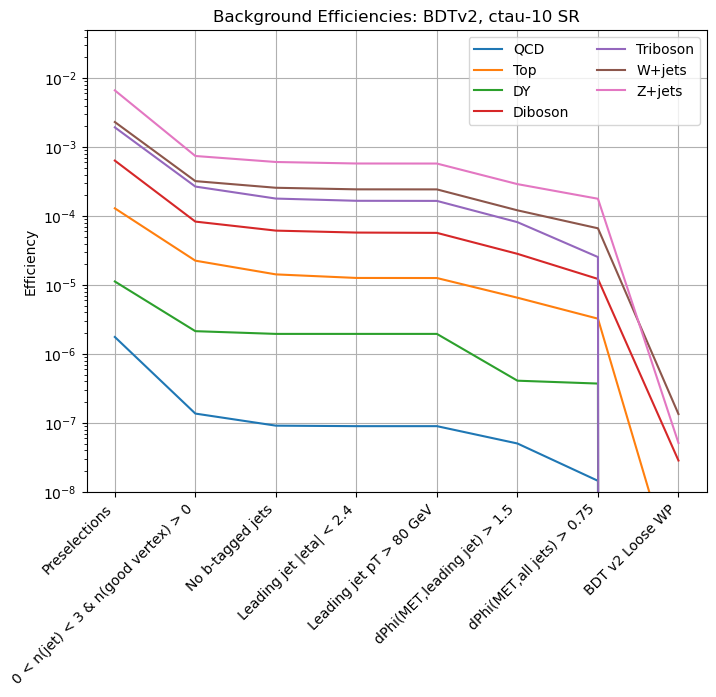

In [92]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title("Background Efficiencies: BDTv2, ctau-10 SR")

for b in bkg_histos.keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
#plt.savefig(f"plots/cutflows/bkg_combined_efficiencies.png")

### Bkg Yield

In [93]:
sqrtB = np.sqrt(bkg_cts_df.iloc[-1].loc['total'])

print('Total background after last SR cut: {:.2f}'.format(bkg_cts_df['total'].iloc[-1]))
print('sqrt(B) = {:.2f}'.format(sqrtB))

Total background after last SR cut: 14.55
sqrt(B) = 3.81


In [94]:
sqrtBs['10'] = sqrtB

### Signal Yield and Vtx Gen Matching Fraction

In [95]:
s_df = sig_cts_df.iloc[-1]
s_match_df = sig_match_df.iloc[-1]

# when only looking at the events where gen ee are reconstructed (dR(gen,reco)<0.1)
s_reco_df = sig_cts_reco_df.iloc[-1]
s_match_reco_df = sig_match_reco_df.iloc[-1]

In [96]:
columns_ctau = {'1': {'0p1': [], '0p2': []}, '10': {'0p1': [], '0p2': []}, '100': {'0p1': [], '0p2': []}}

for name in sig_columns:
    
    mchi = ptools.signalPoint(name)['mchi']
    dmchi = ptools.signalPoint(name)['dmchi']
    delta = ptools.signalPoint(name)['delta']

    if 'ctau-10' not in name:
        if delta == 0.1:
            columns_ctau['1']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['1']['0p2'].append(name)
    elif 'ctau-100' not in name:
        if delta == 0.1:
            columns_ctau['10']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['10']['0p2'].append(name)
    else:
        if delta == 0.1:
            columns_ctau['100']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['100']['0p2'].append(name)

ct = '10'
delta = '0p1'
print(columns_ctau[ct][delta])

['sig_2018_Mchi-5p25_dMchi-0p5_ctau-10', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-10', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-10', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-10', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-10', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-10']


In [97]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['10']:
        signal_df[delta][ctau] = s_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_df[delta][ctau].rename(index = {signal_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_df[delta][ctau] = s_match_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_df[delta][ctau].rename(index = {signal_match_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [98]:
print('Signal yield for delta = 0.1, ctau = 10')
signal_df['0p1']['10'].transpose()

Signal yield for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,61.953124
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,54.642109
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,619.921151
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,37.085564
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,14.612410
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,63.493590


In [99]:
print('Vertex purity for delta = 0.1, ctau = 10')
signal_match_df['0p1']['10'].transpose()

Vertex purity for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,0.927515
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,0.888826
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,0.940642
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,0.941476
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,0.949213
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,0.962956


In [100]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['10']:
        signal_reco_df[delta][ctau] = s_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_reco_df[delta][ctau].rename(index = {signal_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_reco_df[delta][ctau] = s_match_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_reco_df[delta][ctau].rename(index = {signal_match_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [101]:
print('Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10')
signal_reco_df['0p1']['10'].transpose()

Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,60.155277
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,51.373933
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,593.644812
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,35.864057
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,14.194927
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,61.141514


In [102]:
print('Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10')
signal_match_reco_df['0p1']['10'].transpose()

Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,0.955236
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,0.945369
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,0.982278
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,0.973542
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,0.977130
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,1.000000


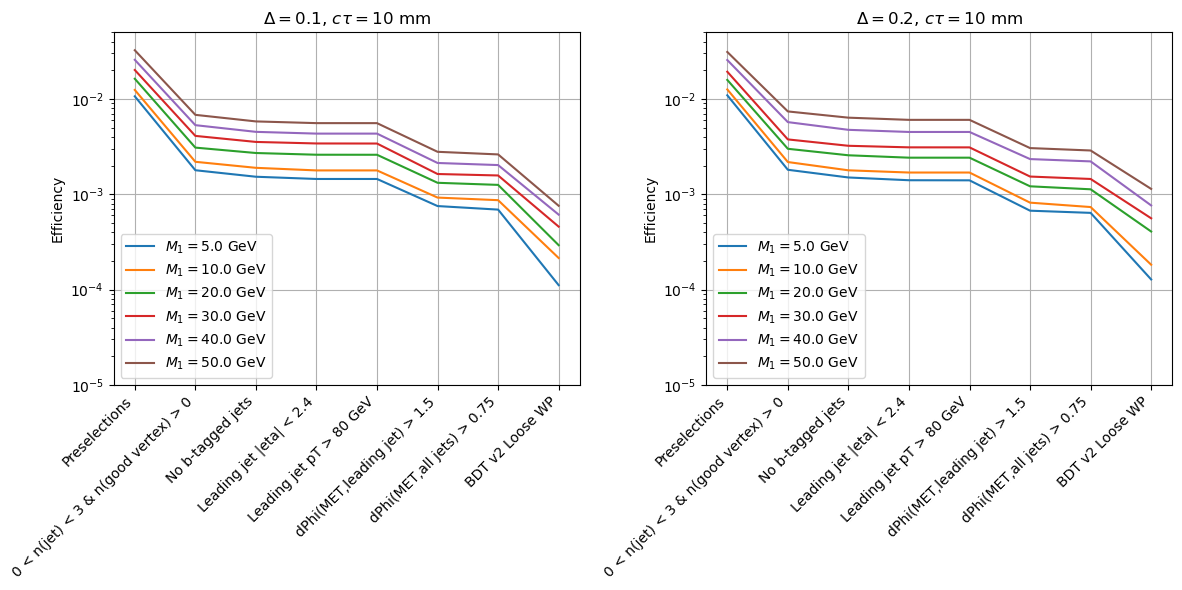

In [103]:
deltas = [0.1,0.2]

ct = 10

fig,axes = plt.subplots(1,len(deltas),figsize=(6*len(deltas),6))

for i, delta in enumerate(deltas):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

## Ctau-100

### Import coffea files -- signal and background

In [104]:
prefix = './coffea/skimmed/'
suffix = '_SR_BDTv2_ctau-100_5to50_skimmed'

In [105]:
# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

In [106]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

### Cutflow Dataframe -- signal

In [107]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

In [108]:
# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

In [109]:
# signal efficiencies, when only looking at the events where the gen ee are reconstructed (dR(gen,reco) < 0.1)
cf_s_reco = sig_histo['cutflow_genEEreconstructed']              # efficiency
ct_s_reco = sig_histo['cutflow_cts_genEEreconstructed']          # xsec-weighted event count
fr_s_reco = sig_histo['cutflow_vtx_matched_genEEreconstructed']  # fraction that selected vtx is truth-matched, for signal

In [110]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}

In [111]:
deltas = sorted(list(set(si.delta)))

#### For signal events

In [112]:
sig_columns = list(cf_s.keys())
sig_efficiency = {c: [ cf_s[samp][c] for samp in sig_columns ] for c in cuts}
sig_match = {c: [ fr_s[samp][c] for samp in sig_columns ] for c in cuts}

In [113]:
sig_eff_df = pd.DataFrame.from_dict(sig_efficiency).transpose()
sig_eff_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_df.index = cut

In [114]:
sig_eff_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,0.007414,0.001127,0.000981,0.000933,0.000933,0.000501,0.000463,0.000037
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,0.022439,0.003937,0.003324,0.003218,0.003218,0.001566,0.001463,0.000299
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,0.007304,0.001070,0.000907,0.000853,0.000853,0.000433,0.000403,0.000022
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.022522,0.003791,0.003235,0.003128,0.003128,0.001572,0.001459,0.000249
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,0.017759,0.002969,0.002463,0.002355,0.002355,0.001149,0.001071,0.000189
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,0.013585,0.002093,0.001752,0.001703,0.001703,0.000856,0.000792,0.000133
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,0.017686,0.002805,0.002384,0.002307,0.002307,0.001142,0.001067,0.000182
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,0.013533,0.002087,0.001809,0.001734,0.001734,0.000861,0.000791,0.000093
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,0.010335,0.001509,0.001295,0.001247,0.001247,0.000672,0.000611,0.000118
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,0.010649,0.001609,0.001411,0.001343,0.001343,0.000689,0.000631,0.000069


In [115]:
sig_counts = {c: [ ct_s[samp][c] for samp in sig_columns ] for c in cuts}

In [116]:
sig_cts_df = pd.DataFrame.from_dict(sig_counts).transpose()
sig_cts_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_df.index = cut

In [117]:
sig_cts_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,14.287467,2.172012,1.889810,1.798029,1.798029,0.964834,0.892673,0.072227
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.367489,0.239920,0.202577,0.196122,0.196122,0.095435,0.089176,0.018192
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,443.518062,64.955403,55.049808,51.817682,51.817682,26.284870,24.501952,1.327252
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,43.757279,7.364887,6.285853,6.077303,6.077303,3.054205,2.834369,0.484675
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,3.387082,0.566187,0.469794,0.449245,0.449245,0.219133,0.204335,0.035986
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1302.773429,200.743999,168.009549,163.334153,163.334153,82.130749,75.987726,12.786245
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,108.959604,17.279938,14.685996,14.210940,14.210940,7.035351,6.574257,1.118656
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,24702.134075,3809.828136,3301.810971,3165.085027,3165.085027,1571.161676,1443.421802,170.463258
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,6.142378,0.896654,0.769692,0.741151,0.741151,0.399612,0.363191,0.069884
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,200.845692,30.341982,26.620781,25.321075,25.321075,12.987289,11.909674,1.299655


In [118]:
sig_match_df = pd.DataFrame.from_dict(sig_match).transpose()
sig_match_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_df.index = cut

In [119]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,1.0,0.066503,0.069479,0.069378,0.069378,0.068096,0.073600,0.818166
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.0,0.187506,0.196018,0.197482,0.197482,0.198813,0.201799,0.924689
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.0,0.048495,0.048947,0.049602,0.049602,0.041023,0.044008,0.781115
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,1.0,0.149223,0.152865,0.153013,0.153013,0.162352,0.167001,0.895246
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,1.0,0.169019,0.177705,0.175817,0.175817,0.181796,0.185531,0.910739
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1.0,0.144585,0.146420,0.150611,0.150611,0.149692,0.152082,0.903812
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.0,0.137197,0.141424,0.141735,0.141735,0.153049,0.158483,0.918844
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,1.0,0.103473,0.102710,0.102654,0.102654,0.105093,0.109461,0.874943
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,1.0,0.132847,0.134296,0.132827,0.132827,0.160118,0.168041,0.859236
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.0,0.080807,0.080151,0.083292,0.083292,0.094413,0.098857,0.886998


#### For signal events having gen ee reconstructed (having reco e with dR < 0.1)

In [120]:
sig_columns_reco = list(cf_s_reco.keys())
sig_efficiency_reco = {c: [ cf_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}
sig_match_reco = {c: [ fr_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [121]:
sig_eff_reco_df = pd.DataFrame.from_dict(sig_efficiency_reco).transpose()
sig_eff_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_reco_df.index = cut

In [122]:
sig_eff_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,sig_2018_Mchi-11p0_dMchi-2p0_ctau-100,sig_2018_Mchi-10p5_dMchi-1p0_ctau-100
Preselections,0.000429,0.004794,0.000302,0.003601,0.003346,0.002362,0.002573,0.001738,0.001522,0.001148,0.000805,0.000557
0 < n(jet) < 3 & n(good vertex) > 0,0.000140,0.001300,0.000096,0.000938,0.000805,0.000526,0.000632,0.000393,0.000338,0.000269,0.000160,0.000145
No b-tagged jets,0.000123,0.001114,0.000082,0.000802,0.000694,0.000446,0.000549,0.000338,0.000301,0.000239,0.000136,0.000125
Leading jet |eta| < 2.4,0.000119,0.001085,0.000078,0.000776,0.000667,0.000444,0.000536,0.000325,0.000287,0.000234,0.000134,0.000117
Leading jet pT > 80 GeV,0.000119,0.001085,0.000078,0.000776,0.000667,0.000444,0.000536,0.000325,0.000287,0.000234,0.000134,0.000117
"dPhi(MET,leading jet) > 1.5",0.000058,0.000555,0.000036,0.000403,0.000320,0.000231,0.000267,0.000163,0.000171,0.000135,0.000052,0.000055
"dPhi(MET,all jets) > 0.75",0.000058,0.000517,0.000034,0.000377,0.000303,0.000213,0.000255,0.000156,0.000166,0.000130,0.000051,0.000052
BDT v2 Loose WP,0.000031,0.000289,0.000018,0.000232,0.000172,0.000128,0.000173,0.000085,0.000103,0.000062,0.000027,0.000029


In [123]:
sig_counts_reco = {c: [ ct_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [124]:
sig_cts_reco_df = pd.DataFrame.from_dict(sig_counts_reco).transpose()
sig_cts_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_reco_df.index = cut

In [125]:
sig_cts_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,sig_2018_Mchi-11p0_dMchi-2p0_ctau-100,sig_2018_Mchi-10p5_dMchi-1p0_ctau-100
Preselections,0.827147,0.292147,18.364086,6.996573,0.638121,226.543294,15.852945,3172.494297,0.904543,21.643236,0.766447,16.546979
0 < n(jet) < 3 & n(good vertex) > 0,0.269058,0.079208,5.844165,1.823054,0.153527,50.409151,3.894721,717.339756,0.200838,5.075234,0.152475,4.308990
No b-tagged jets,0.236236,0.067871,4.974496,1.558310,0.132334,42.787908,3.383979,616.112208,0.179176,4.512204,0.129125,3.715923
Leading jet |eta| < 2.4,0.229679,0.066109,4.725970,1.507583,0.127192,42.543836,3.300273,593.028614,0.170314,4.414175,0.127758,3.478691
Leading jet pT > 80 GeV,0.229679,0.066109,4.725970,1.507583,0.127192,42.543836,3.300273,593.028614,0.170314,4.414175,0.127758,3.478691
"dPhi(MET,leading jet) > 1.5",0.111603,0.033836,2.156838,0.783234,0.061020,22.120992,1.642726,298.291884,0.101413,2.548895,0.049492,1.640500
"dPhi(MET,all jets) > 0.75",0.111603,0.031491,2.073974,0.732544,0.057809,20.401103,1.573000,284.116605,0.098459,2.451166,0.048119,1.541610
BDT v2 Loose WP,0.059094,0.017605,1.078242,0.450807,0.032774,12.293564,1.062782,154.469727,0.061032,1.177299,0.026113,0.869924


In [126]:
sig_match_reco_df = pd.DataFrame.from_dict(sig_match_reco).transpose()
sig_match_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_reco_df.index = cut

In [127]:
sig_match_reco_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,1.0,0.536858,0.555805,0.543122,0.543122,0.588702,0.588702,1.000000
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.0,0.567949,0.585065,0.585857,0.585857,0.560749,0.571449,0.955513
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.0,0.538997,0.541671,0.543864,0.543864,0.499939,0.519914,0.961506
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,1.0,0.602840,0.616621,0.616820,0.616820,0.633089,0.646161,0.962503
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,1.0,0.623318,0.630866,0.620991,0.620991,0.652858,0.655787,1.000000
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1.0,0.575781,0.574926,0.578224,0.578224,0.555775,0.566458,0.940033
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.0,0.608711,0.613760,0.610308,0.610308,0.655469,0.662372,0.967151
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,1.0,0.549551,0.550432,0.547882,0.547882,0.553546,0.556105,0.965533
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,1.0,0.593103,0.576899,0.578018,0.578018,0.630938,0.619865,0.983855
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.0,0.483099,0.472867,0.477788,0.477788,0.481058,0.480324,0.979183


In [128]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,1.0,0.066503,0.069479,0.069378,0.069378,0.068096,0.073600,0.818166
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.0,0.187506,0.196018,0.197482,0.197482,0.198813,0.201799,0.924689
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.0,0.048495,0.048947,0.049602,0.049602,0.041023,0.044008,0.781115
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,1.0,0.149223,0.152865,0.153013,0.153013,0.162352,0.167001,0.895246
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,1.0,0.169019,0.177705,0.175817,0.175817,0.181796,0.185531,0.910739
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1.0,0.144585,0.146420,0.150611,0.150611,0.149692,0.152082,0.903812
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.0,0.137197,0.141424,0.141735,0.141735,0.153049,0.158483,0.918844
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,1.0,0.103473,0.102710,0.102654,0.102654,0.105093,0.109461,0.874943
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,1.0,0.132847,0.134296,0.132827,0.132827,0.160118,0.168041,0.859236
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.0,0.080807,0.080151,0.083292,0.083292,0.094413,0.098857,0.886998


### Cutflow Dataframe -- background

In [129]:
cuts = list(bkg_histos['W+jets']['cutflow']['bkg_2018_WJetsLNu_HT2500toInf'])

In [130]:
tot_bkg_cts = {} 
tot_bkg_effs = {} 
total_bkg_counts = {} 

In [131]:
for b in bkg_histos.keys():
    
    total_bkg_counts[b] = 0
    for k in bkg_histos[b]['cutflow'].keys():
        total_bkg_counts[b] += bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']

In [132]:
for b in bkg_histos.keys():
    cfd = bkg_histos[b]['cutflow_cts']
    effd = bkg_histos[b]['cutflow']

    cts_dict = {k:0 for k in cuts}
    
    for k in cfd.keys():
        for c in cuts:
            cts_dict[c] += cfd[k][c]

    tot_bkg_cts[b] = cts_dict # subprocess summed
    tot_bkg_effs[b] = {c:cts_dict[c]/total_bkg_counts[b] for c in cuts}

In [133]:
bkg_summed_cts = {c:sum([tot_bkg_cts[b][c] for b in tot_bkg_cts.keys()]) for c in cuts}

In [134]:
bkg_summed_eff = {c: bkg_summed_cts[c] / sum(total_bkg_counts.values()) for c in cuts}

In [135]:
bkg_columns = list(bkg_histos.keys())
bkg_columns.append('total')

tot_bkg_effs['total'] = bkg_summed_eff
tot_bkg_cts['total'] = bkg_summed_cts

In [136]:
bkg_efficiency = {c: [ tot_bkg_effs[samp][c] for samp in bkg_columns ] for c in cuts}
bkg_counts = {c: [ tot_bkg_cts[samp][c] for samp in bkg_columns ] for c in cuts}

In [137]:
bkg_eff_df = pd.DataFrame.from_dict(bkg_efficiency).transpose()
bkg_eff_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_eff_df.index = cut

In [138]:
bkg_eff_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,1.765167e-06,1.294682e-04,1.126054e-05,6.373026e-04,1.932566e-03,2.309964e-03,6.645339e-03,1.878092e-05
0 < n(jet) < 3 & n(good vertex) > 0,1.367991e-07,2.255081e-05,2.142595e-06,8.314492e-05,2.677966e-04,3.211313e-04,7.430600e-04,2.380365e-06
No b-tagged jets,9.141417e-08,1.426770e-05,1.956258e-06,6.151165e-05,1.793469e-04,2.572087e-04,6.081179e-04,1.906242e-06
Leading jet |eta| < 2.4,8.988998e-08,1.266725e-05,1.956258e-06,5.764339e-05,1.664985e-04,2.440454e-04,5.783924e-04,1.816663e-06
Leading jet pT > 80 GeV,8.988998e-08,1.263126e-05,1.956258e-06,5.705314e-05,1.658857e-04,2.435975e-04,5.773879e-04,1.813567e-06
"dPhi(MET,leading jet) > 1.5",5.039459e-08,6.550830e-06,4.101039e-07,2.834303e-05,8.160181e-05,1.211213e-04,2.905525e-04,8.793299e-07
"dPhi(MET,all jets) > 0.75",1.448723e-08,3.252501e-06,3.726753e-07,1.225552e-05,2.545817e-05,6.645713e-05,1.782490e-04,4.942504e-07
BDT v2 Loose WP,0.000000e+00,1.219407e-09,0.000000e+00,1.123917e-07,4.581503e-07,1.012620e-07,1.279476e-07,5.886963e-10


In [139]:
bkg_cts_df = pd.DataFrame.from_dict(bkg_counts).transpose()
bkg_cts_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_cts_df.index = cut

In [140]:
bkg_cts_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,38039.826987,5667.491120,14495.724273,4424.202428,52.996922,227212.601036,142220.153499,432112.996264
0 < n(jet) < 3 & n(good vertex) > 0,2948.058507,987.165470,2758.167766,577.198283,7.343808,31587.113375,15902.592237,54767.639446
No b-tagged jets,1970.000354,624.570742,2518.294909,427.018510,4.918245,25299.553501,13014.629253,43858.985515
Leading jet |eta| < 2.4,1937.153597,554.510975,2518.294909,400.164705,4.565901,24004.791359,12378.460352,41797.941797
Leading jet pT > 80 GeV,1937.153597,552.935342,2518.294909,396.067158,4.549098,23960.729450,12356.962136,41726.691689
"dPhi(MET,leading jet) > 1.5",1086.017143,286.763600,527.927667,196.759431,2.237773,11913.733813,6218.256953,20231.696380
"dPhi(MET,all jets) > 0.75",312.203722,142.378761,479.745714,85.078707,0.698141,6536.855494,3814.794152,11371.754691
BDT v2 Loose WP,0.000000,0.053380,0.000000,0.780231,0.012564,9.960329,2.738270,13.544773


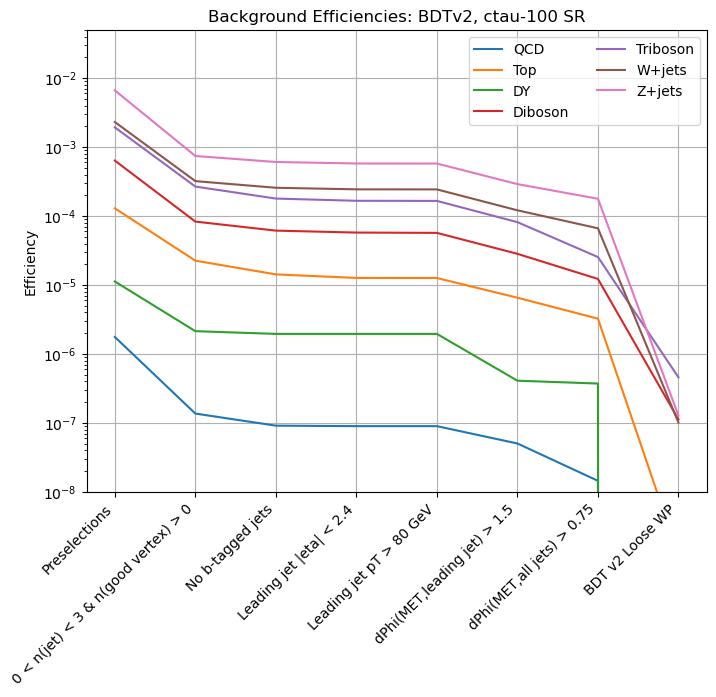

In [141]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title("Background Efficiencies: BDTv2, ctau-100 SR")

for b in bkg_histos.keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
#plt.savefig(f"plots/cutflows/bkg_combined_efficiencies.png")

### Bkg Yield

In [142]:
sqrtB = np.sqrt(bkg_cts_df.iloc[-1].loc['total'])

print('Total background after last SR cut: {:.2f}'.format(bkg_cts_df['total'].iloc[-1]))
print('sqrt(B) = {:.2f}'.format(sqrtB))

Total background after last SR cut: 13.54
sqrt(B) = 3.68


In [143]:
sqrtBs['100'] = sqrtB

### Signal Yield and Vtx Gen Matching Fraction

In [144]:
s_df = sig_cts_df.iloc[-1]
s_match_df = sig_match_df.iloc[-1]

# when only looking at the events where gen ee are reconstructed (dR(gen,reco)<0.1)
s_reco_df = sig_cts_reco_df.iloc[-1]
s_match_reco_df = sig_match_reco_df.iloc[-1]

In [145]:
columns_ctau = {'1': {'0p1': [], '0p2': []}, '10': {'0p1': [], '0p2': []}, '100': {'0p1': [], '0p2': []}}

for name in sig_columns:
    
    mchi = ptools.signalPoint(name)['mchi']
    dmchi = ptools.signalPoint(name)['dmchi']
    delta = ptools.signalPoint(name)['delta']

    if 'ctau-10' not in name:
        if delta == 0.1:
            columns_ctau['1']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['1']['0p2'].append(name)
    elif 'ctau-100' not in name:
        if delta == 0.1:
            columns_ctau['10']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['10']['0p2'].append(name)
    else:
        if delta == 0.1:
            columns_ctau['100']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['100']['0p2'].append(name)

ct = '100'
delta = '0p1'
print(columns_ctau[ct][delta])

['sig_2018_Mchi-5p25_dMchi-0p5_ctau-100', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-100', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-100', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-100', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-100']


In [146]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['100']:
        signal_df[delta][ctau] = s_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_df[delta][ctau].rename(index = {signal_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_df[delta][ctau] = s_match_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_df[delta][ctau].rename(index = {signal_match_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [147]:
print('Signal yield for delta = 0.1, ctau = 100')
signal_df['0p1']['100'].transpose()

Signal yield for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,1.107226
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.299655
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,170.463258
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.118656
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.484675
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.327252


In [148]:
print('Vertex purity for delta = 0.1, ctau = 100')
signal_match_df['0p1']['100'].transpose()

Vertex purity for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,0.750077
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,0.886998
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,0.874943
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,0.918844
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.895246
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,0.781115


In [149]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['100']:
        signal_reco_df[delta][ctau] = s_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_reco_df[delta][ctau].rename(index = {signal_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_reco_df[delta][ctau] = s_match_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_reco_df[delta][ctau].rename(index = {signal_match_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [150]:
print('Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100')
signal_reco_df['0p1']['100'].transpose()

Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,0.869924
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.177299
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,154.469727
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.062782
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.450807
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.078242


In [151]:
print('Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100')
signal_match_reco_df['0p1']['100'].transpose()

Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,0.954688
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,0.979183
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,0.965533
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,0.967151
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.962503
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,0.961506


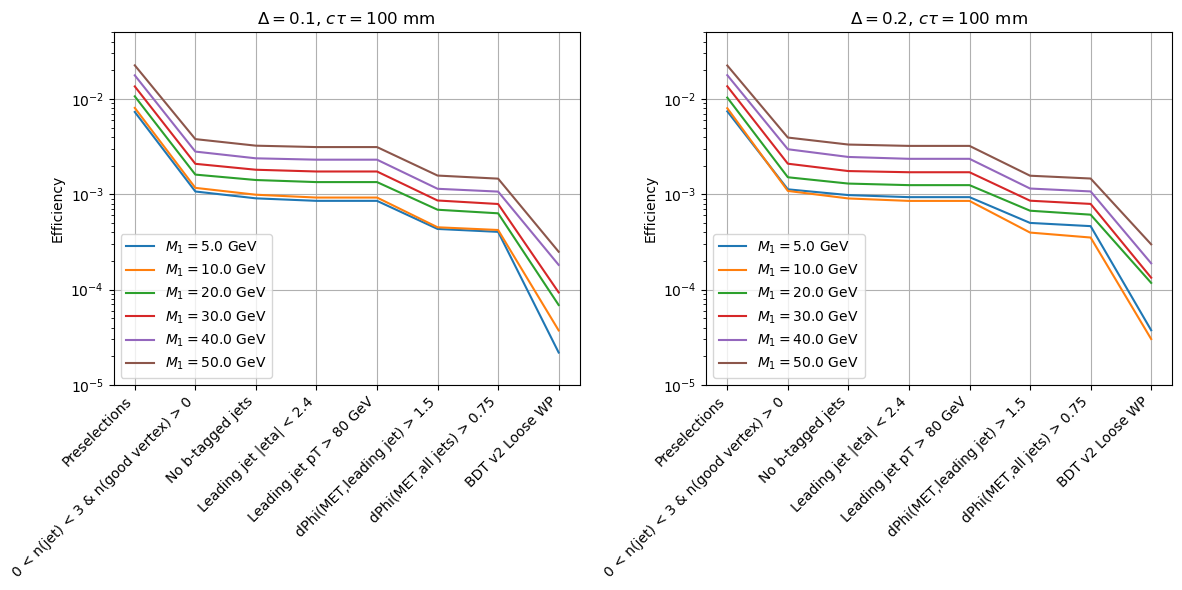

In [152]:
deltas = [0.1,0.2]

ct = 100

fig,axes = plt.subplots(1,len(deltas),figsize=(6*len(deltas),6))

for i, delta in enumerate(deltas):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

## Signal Yield for all ctaus

In [153]:
ctaus = ['1','10','100']

In [154]:
delta = '0p1'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_df[delta][ctau].columns]
    signal_df[delta][ctau].columns = m1s

    signal_df[delta][ctau] = signal_df[delta][ctau].sort_index(axis=1)

frames = [signal_df[delta]['1'], signal_df[delta]['10'], signal_df[delta]['100']]
delta_0p1_df = pd.concat(frames)

In [155]:
print('delta = 0p1, signal yield after last cut in SR')
delta_0p1_df

delta = 0p1, signal yield after last cut in SR


,5,10,20,30,40,50
1mm,1753.241080,1072.262222,854.407333,960.999523,499.574489,214.119277
10mm,63.493590,61.953124,54.642109,619.921151,37.085564,14.612410
100mm,1.327252,1.107226,1.299655,170.463258,1.118656,0.484675


In [156]:
for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_reco_df[delta][ctau].columns]
    signal_reco_df[delta][ctau].columns = m1s

    signal_reco_df[delta][ctau] = signal_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_reco_df[delta]['1'], signal_reco_df[delta]['10'], signal_reco_df[delta]['100']]
delta_0p1_reco_df = pd.concat(frames)

In [157]:
print('delta = 0p1, signal yield for events where gen ee are reconstructed, after last cut in SR')
delta_0p1_reco_df

delta = 0p1, signal yield for events where gen ee are reconstructed, after last cut in SR


,5,10,20,30,40,50
1mm,1753.241080,1056.214305,840.281822,950.905053,495.470809,212.055682
10mm,61.141514,60.155277,51.373933,593.644812,35.864057,14.194927
100mm,1.078242,0.869924,1.177299,154.469727,1.062782,0.450807


In [158]:
# take care of missing sample with dummy column
signal_df['0p2']['1'].insert(3, 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-1', 0)
signal_reco_df['0p2']['1'].insert(3, 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-1', 0)

signal_match_df['0p2']['1'].insert(3, 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-1', 0)
signal_match_reco_df['0p2']['1'].insert(3, 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-1', 0)

signal_match_reco_df['0p2']['1']

,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,sig_2018_Mchi-44p0_dMchi-8p0_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1
1mm,0.9697,0.962294,0.971339,0,0.978932,0.97215


In [159]:
delta = '0p2'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_df[delta][ctau].columns]
    signal_df[delta][ctau].columns = m1s

    signal_df[delta][ctau] = signal_df[delta][ctau].sort_index(axis=1)

frames = [signal_df[delta]['1'], signal_df[delta]['10'], signal_df[delta]['100']]
delta_0p2_df = pd.concat(frames)

In [160]:
print('delta = 0p2, signal yield after last cut in SR')
delta_0p2_df

delta = 0p2, signal yield after last cut in SR


,5,10,20,30,40,50
1mm,62.608122,42.245148,37.158979,2143.166005,0.000000,9.722081
10mm,2.474059,1.715769,2.413679,450.970841,1.462790,0.693663
100mm,0.072227,0.028866,0.069884,12.786245,0.035986,0.018192


In [161]:
delta = '0p2'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_reco_df[delta][ctau].columns]
    signal_reco_df[delta][ctau].columns = m1s

    signal_reco_df[delta][ctau] = signal_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_reco_df[delta]['1'], signal_reco_df[delta]['10'], signal_reco_df[delta]['100']]
delta_0p2_reco_df = pd.concat(frames)

In [162]:
print('delta = 0p2, signal yield for events where gen ee are reconstructed, after last cut in SR')
delta_0p2_reco_df

delta = 0p2, signal yield for events where gen ee are reconstructed, after last cut in SR


,5,10,20,30,40,50
1mm,61.318683,42.245148,37.158979,2071.878345,0.000000,9.722081
10mm,2.407127,1.631483,2.288508,438.975615,1.462790,0.693663
100mm,0.059094,0.026113,0.061032,12.293564,0.032774,0.017605


## Display S/B

In [163]:
pd.set_option("display.precision", 3)

In [164]:
delta = '0p1'

frames = [delta_0p1_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p1_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p1_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p1_SoverB_df = pd.concat(frames)

delta_0p1_SoverB_df = delta_0p1_SoverB_df.sort_index(axis=1)

In [165]:
print('delta = 0.1, S/sqrt(B)')

delta_0p1_SoverB_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_SoverB_df

delta = 0.1, S/sqrt(B)


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,378.667,231.588,184.536,207.557,107.899,46.246
10mm,16.647,16.243,14.326,162.529,9.723,3.831
100mm,0.361,0.301,0.353,46.317,0.304,0.132


In [166]:
delta = '0p1'

frames = [delta_0p1_reco_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p1_reco_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p1_reco_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p1_SoverB_reco_df = pd.concat(frames)

delta_0p1_SoverB_reco_df = delta_0p1_SoverB_reco_df.sort_index(axis=1)

print('delta = 0.1, S/sqrt(B), only counting the signal events where gen ee are reconstructed')

delta_0p1_SoverB_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_SoverB_reco_df

delta = 0.1, S/sqrt(B), only counting the signal events where gen ee are reconstructed


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,378.667,228.122,181.485,205.377,107.012,45.800
10mm,16.030,15.771,13.469,155.640,9.403,3.722
100mm,0.293,0.236,0.320,41.972,0.289,0.122


In [167]:
delta = '0p2'

frames = [delta_0p2_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p2_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p2_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p2_SoverB_df = pd.concat(frames)

delta_0p2_SoverB_df = delta_0p2_SoverB_df.sort_index(axis=1)

In [168]:
print('delta = 0.2, S/sqrt(B)')

delta_0p2_SoverB_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_SoverB_df

delta = 0.2, S/sqrt(B)


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,13.522,9.124,8.026,462.883,0.000,2.100
10mm,0.649,0.450,0.633,118.234,0.384,0.182
100mm,0.020,0.008,0.019,3.474,0.010,0.005


In [169]:
delta = '0p2'

frames = [delta_0p2_reco_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p2_reco_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p2_reco_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p2_SoverB_reco_df = pd.concat(frames)

delta_0p2_SoverB_reco_df = delta_0p2_SoverB_reco_df.sort_index(axis=1)

print('delta = 0.2, S/sqrt(B), only counting the signal events where gen ee are reconstructed')

delta_0p2_SoverB_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_SoverB_reco_df

delta = 0.2, S/sqrt(B), only counting the signal events where gen ee are reconstructed


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,13.244,9.124,8.026,447.486,0.000,2.100
10mm,0.631,0.428,0.600,115.089,0.384,0.182
100mm,0.016,0.007,0.017,3.340,0.009,0.005


In [170]:
ctaus = [1,10,100]

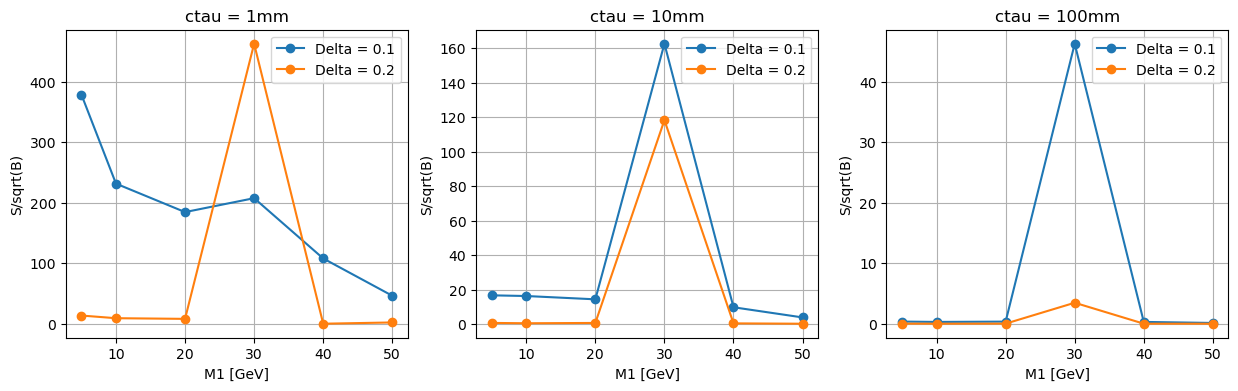

In [171]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, ctau in enumerate(ctaus):
    ctau = int(ctau)
    
    y_arr_1 = delta_0p1_SoverB_df.iloc[idx].to_list()
    y_arr_2 = delta_0p2_SoverB_df.iloc[idx].to_list()

    x_arr = sorted(m1s)
    
    axes[idx].plot(x_arr, y_arr_1, '-o', label=f'Delta = 0.1')
    axes[idx].plot(x_arr, y_arr_2, '-o', label=f'Delta = 0.2')

    axes[idx].legend()
    
    axes[idx].set_xlabel('M1 [GeV]')
    axes[idx].set_ylabel('S/sqrt(B)')
    
    axes[idx].grid()
    
    axes[idx].set_title(f'ctau = {ctau}mm')

## Vtx purity (fraction of events whose selected vertex is gen matched) for all ctaus

In [172]:
ctaus = ['1','10','100']

In [173]:
delta = '0p1'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_df[delta][ctau].columns]
    signal_match_df[delta][ctau].columns = m1s

    signal_match_df[delta][ctau] = signal_match_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_df[delta]['1'], signal_match_df[delta]['10'], signal_match_df[delta]['100']]
delta_0p1_match_df = pd.concat(frames)

In [174]:
print('BDTv2 SR')
print('delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]')

delta_0p1_match_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_match_df

BDTv2 SR
delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.990,0.965,0.959,0.948,0.973,0.964
10mm,0.963,0.928,0.889,0.941,0.941,0.949
100mm,0.781,0.750,0.887,0.875,0.919,0.895


In [175]:
for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_reco_df[delta][ctau].columns]
    signal_match_reco_df[delta][ctau].columns = m1s

    signal_match_reco_df[delta][ctau] = signal_match_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_reco_df[delta]['1'], signal_match_reco_df[delta]['10'], signal_match_reco_df[delta]['100']]
delta_0p1_match_reco_df = pd.concat(frames)

In [176]:
print('BDTv2 SR')
print('delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]')
delta_0p1_match_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_match_reco_df

BDTv2 SR
delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.990,0.980,0.975,0.958,0.981,0.973
10mm,1.000,0.955,0.945,0.982,0.974,0.977
100mm,0.962,0.955,0.979,0.966,0.967,0.963


In [177]:
delta = '0p2'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_df[delta][ctau].columns]
    signal_match_df[delta][ctau].columns = m1s

    signal_match_df[delta][ctau] = signal_match_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_df[delta]['1'], signal_match_df[delta]['10'], signal_match_df[delta]['100']]
delta_0p2_match_df = pd.concat(frames)

In [178]:
print('BDTv2 SR')
print('delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]')

delta_0p2_match_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_match_df

BDTv2 SR
delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.959,0.970,0.962,0.939,0.000,0.972
10mm,0.946,0.921,0.915,0.947,0.959,0.992
100mm,0.818,0.905,0.859,0.904,0.911,0.925


In [179]:
for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_reco_df[delta][ctau].columns]
    signal_match_reco_df[delta][ctau].columns = m1s

    signal_match_reco_df[delta][ctau] = signal_match_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_reco_df[delta]['1'], signal_match_reco_df[delta]['10'], signal_match_reco_df[delta]['100']]
delta_0p2_match_reco_df = pd.concat(frames)

In [180]:
print('BDTv2 SR')
print('delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]')
delta_0p2_match_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_match_reco_df

BDTv2 SR
delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.979,0.970,0.962,0.971,0.000,0.972
10mm,0.972,0.969,0.965,0.973,0.959,0.992
100mm,1.000,1.000,0.984,0.940,1.000,0.956


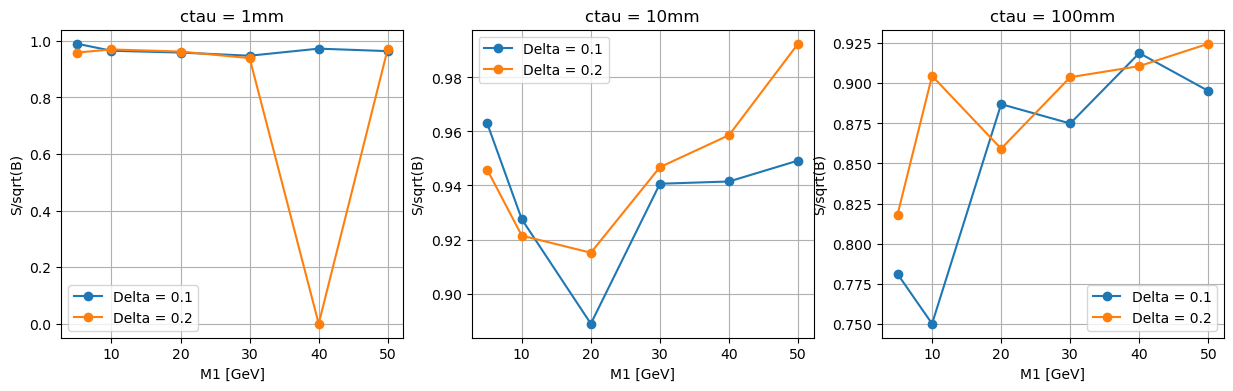

In [181]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, ctau in enumerate(ctaus):
    ctau = int(ctau)
    
    y_arr_1 = delta_0p1_match_df.iloc[idx].to_list()
    y_arr_2 = delta_0p2_match_df.iloc[idx].to_list()

    x_arr = sorted(m1s)
    
    axes[idx].plot(x_arr, y_arr_1, '-o', label=f'Delta = 0.1')
    axes[idx].plot(x_arr, y_arr_2, '-o', label=f'Delta = 0.2')

    axes[idx].legend()
    
    axes[idx].set_xlabel('M1 [GeV]')
    axes[idx].set_ylabel('S/sqrt(B)')
    
    axes[idx].grid()
    
    axes[idx].set_title(f'ctau = {ctau}mm')

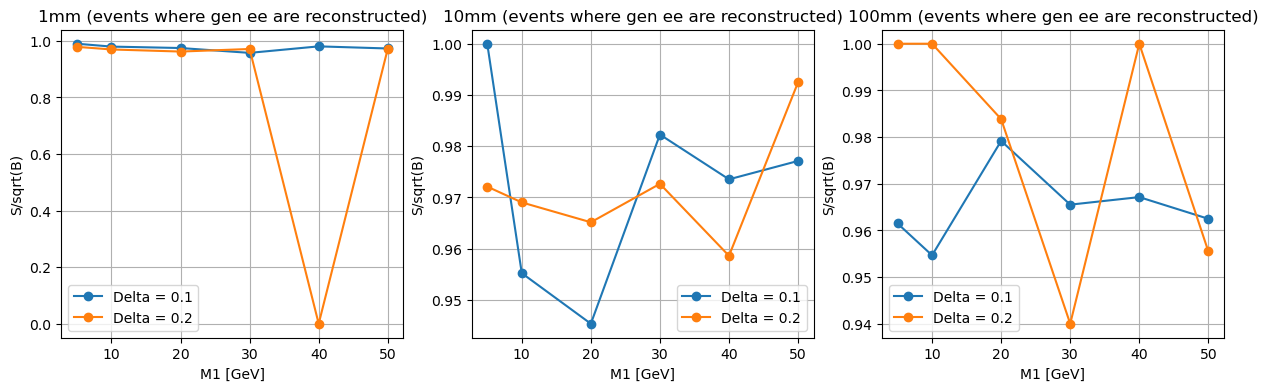

In [182]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, ctau in enumerate(ctaus):
    ctau = int(ctau)
    
    y_arr_1 = delta_0p1_match_reco_df.iloc[idx].to_list()
    y_arr_2 = delta_0p2_match_reco_df.iloc[idx].to_list()

    x_arr = sorted(m1s)
    
    axes[idx].plot(x_arr, y_arr_1, '-o', label=f'Delta = 0.1')
    axes[idx].plot(x_arr, y_arr_2, '-o', label=f'Delta = 0.2')

    axes[idx].legend()
    
    axes[idx].set_xlabel('M1 [GeV]')
    axes[idx].set_ylabel('S/sqrt(B)')
    
    axes[idx].grid()
    
    axes[idx].set_title(f'{ctau}mm (events where gen ee are reconstructed)')

In [183]:
# export
delta_0p1_SoverB_df.to_csv('../BDTv2-based-SR_SoverB_delta_0p1.csv')
delta_0p2_SoverB_df.to_csv('../BDTv2-based-SR_SoverB_delta_0p2.csv') 

# export
delta_0p1_SoverB_reco_df.to_csv('../BDTv2-based-SR_SoverB_delta_0p1_hasGenEEreconstructed.csv')
delta_0p2_SoverB_reco_df.to_csv('../BDTv2-based-SR_SoverB_delta_0p2_hasGenEEreconstructed.csv') 

In [184]:
# export
delta_0p1_match_df.to_csv('../BDTv2-based-SR_Purity_delta_0p1.csv') 
delta_0p2_match_df.to_csv('../BDTv2-based-SR_Purity_delta_0p2.csv') 

delta_0p1_match_reco_df.to_csv('../BDTv2-based-SR_Purity_delta_0p1_hasGenEEreconstructed.csv') 
delta_0p2_match_reco_df.to_csv('../BDTv2-based-SR_Purity_delta_0p2_hasGenEEreconstructed.csv') 

In [185]:
bYields = {}

for bkg in sqrtBs.keys():
    bYields[bkg] = sqrtBs[bkg]**2

pd.DataFrame.from_dict(bYields, orient='index')

,0
1,21.437
10,14.548
100,13.545


## Compare S/B with Other SR

In [186]:
s_over_b = {'Cut': {}, 'BDTv1': {}, 'BDTv2': {}}

for typ in s_over_b.keys():
    for delta in ['0p1','0p2']:
        with open(f'../{typ}-based-SR_SoverB_delta_{delta}.csv') as x:
            ncols = len(x.readline().split(','))
        
        s_over_b[typ][delta] = pd.read_csv(f'../{typ}-based-SR_SoverB_delta_{delta}.csv', usecols=range(1,ncols))

In [187]:
s_over_b['Cut']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,90.490,59.239,54.647,54.646,28.708,12.355
1,5.012,5.489,4.557,51.273,3.185,1.192
2,0.093,0.093,0.118,15.326,0.099,0.044


In [188]:
s_over_b['BDTv1']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,226.846,148.304,116.052,133.050,73.925,31.479
1,19.953,17.004,16.674,190.429,11.117,4.452
2,0.400,0.341,0.344,52.173,0.305,0.138


In [189]:
s_over_b['BDTv1']['0p1']/s_over_b['Cut']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,2.507,2.503,2.124,2.435,2.575,2.548
1,3.981,3.098,3.659,3.714,3.490,3.736
2,4.305,3.667,2.905,3.404,3.089,3.154


In [190]:
s_over_b['BDTv2']['0p1']/s_over_b['Cut']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,4.185,3.909,3.377,3.798,3.759,3.743
1,3.322,2.959,3.144,3.170,3.052,3.214
2,3.878,3.231,2.986,3.022,3.076,3.019


In [191]:
s_over_b['BDTv1']['0p2']/s_over_b['Cut']['0p2']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,2.568,2.268,2.323,2.566,NaN,2.382
1,4.127,4.304,3.294,3.193,4.398,3.672
2,3.333,3.835,2.387,2.910,3.812,4.384


In [192]:
s_over_b['BDTv2']['0p2']/s_over_b['Cut']['0p2']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,3.591,3.597,3.542,3.950,NaN,4.072
1,2.982,3.406,3.137,3.023,3.741,3.507
2,3.332,2.825,2.730,2.798,3.308,3.953


In [193]:
ratio = {'BDTv1': {}, 'BDTv2': {}}

for typ in ratio.keys():
    for delta in ['0p1','0p2']:
        ratio[typ][delta] = s_over_b[typ][delta]/s_over_b['Cut'][delta]

Text(0.5, 1.0, 'Delta = 0.1, Ctau = 1mm')

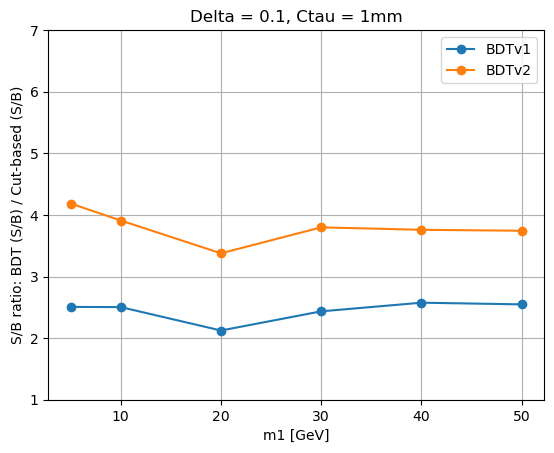

In [194]:
# ctau-1, delta 0.1

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
y_arr1 = ratio['BDTv1']['0p1'].iloc[0].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p1'].iloc[0].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,7])
plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 1mm')

Text(0.5, 1.0, 'Delta = 0.1, Ctau = 10mm')

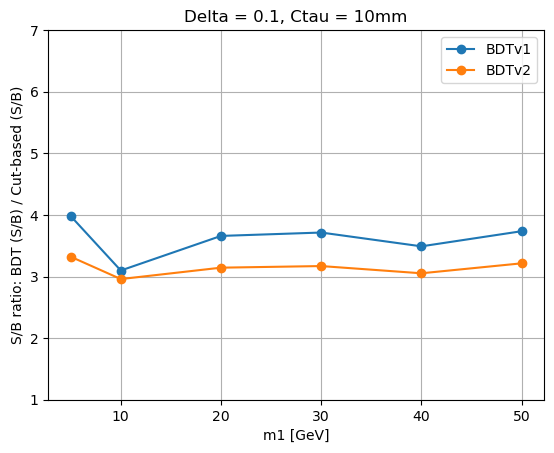

In [195]:
# ctau-1, delta 0.1

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
y_arr1 = ratio['BDTv1']['0p1'].iloc[1].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p1'].iloc[1].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,7])
plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 10mm')

Text(0.5, 1.0, 'Delta = 0.1, Ctau = 100mm')

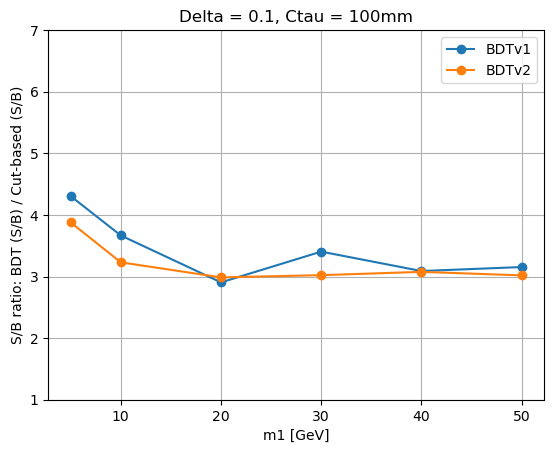

In [196]:
# ctau-100, delta 0.1

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
y_arr1 = ratio['BDTv1']['0p1'].iloc[2].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p1'].iloc[2].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,7])
plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 100mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 1mm')

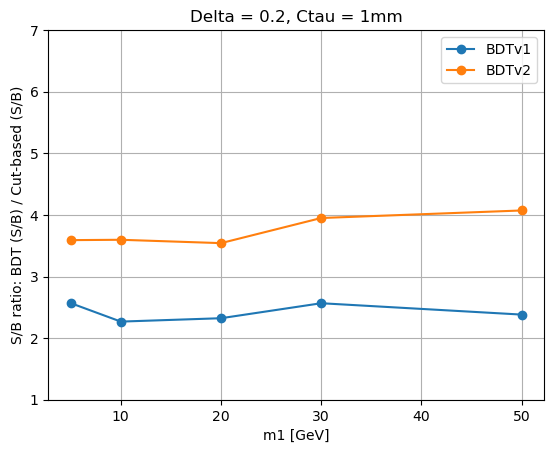

In [197]:
# ctau-1, delta 0.2

x_arr1 = [5,10,20,30,50]
x_arr2 = [5,10,20,30,50]
y_arr1 = ratio['BDTv1']['0p2'].iloc[0].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p2'].iloc[0].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,7])
plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 1mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 10mm')

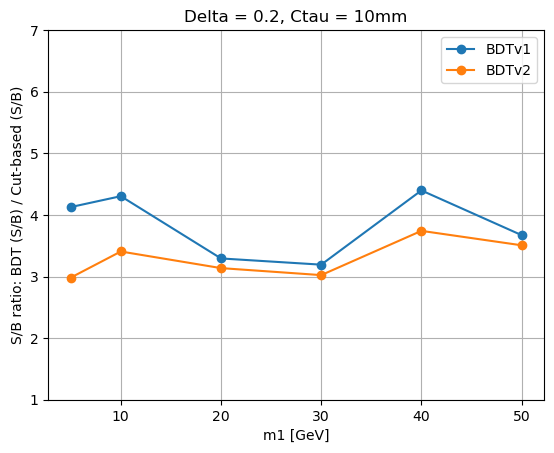

In [198]:
# ctau-1, delta 0.2

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
y_arr1 = ratio['BDTv1']['0p2'].iloc[1].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p2'].iloc[1].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,7])
plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 10mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 100mm')

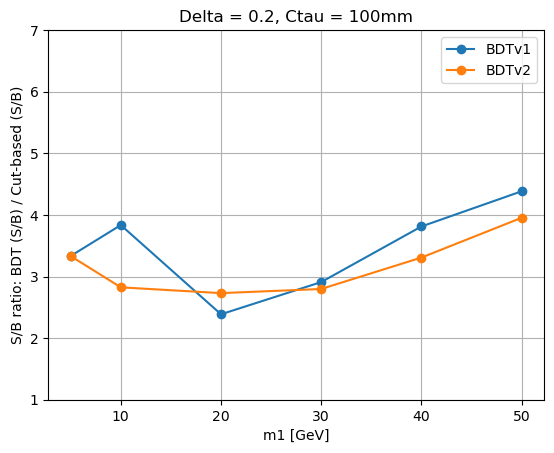

In [199]:
# ctau-100, delta 0.2

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
y_arr1 = ratio['BDTv1']['0p2'].iloc[2].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p2'].iloc[2].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,7])
plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 100mm')

## Compare Vertex Purity with other SR

In [200]:
purity = {'Cut': {}, 'BDTv1': {}, 'BDTv2': {}}

for typ in s_over_b.keys():
    for delta in ['0p1','0p2']:
        with open(f'../{typ}-based-SR_Purity_delta_{delta}.csv') as x:
            ncols = len(x.readline().split(','))
        
        purity[typ][delta] = pd.read_csv(f'../{typ}-based-SR_Purity_delta_{delta}.csv', usecols=range(1,ncols))

In [201]:
purity['Cut']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,0.978,0.980,0.964,0.931,0.963,0.953
1,0.947,0.917,0.931,0.971,0.976,0.961
2,0.800,0.833,0.953,0.870,0.945,0.899


Text(0.5, 1.0, 'Delta = 0.1, Ctau = 1mm')

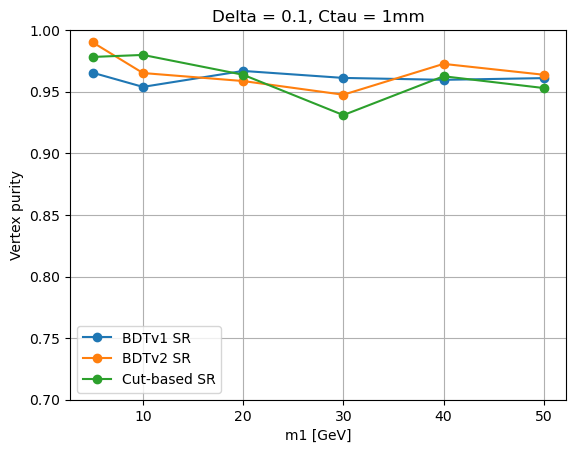

In [202]:
# ctau-1, delta 0.1

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

y_arr1 = purity['BDTv1']['0p1'].iloc[0].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[0].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[0].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 1mm')

Text(0.5, 1.0, 'Delta = 0.1, Ctau = 10mm')

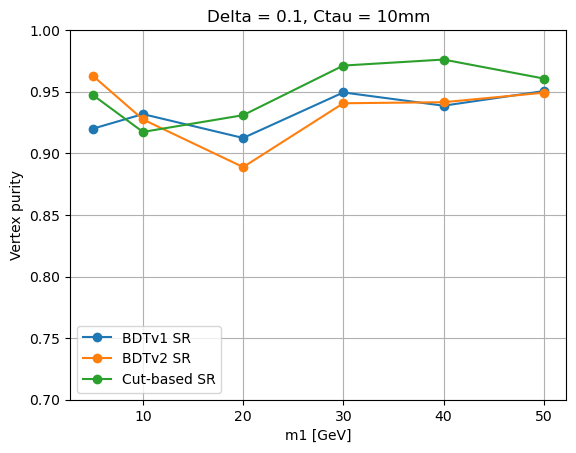

In [203]:
# ctau-10, delta 0.1

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

y_arr1 = purity['BDTv1']['0p1'].iloc[1].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[1].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[1].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 10mm')

Text(0.5, 1.0, 'Delta = 0.1, Ctau = 100mm')

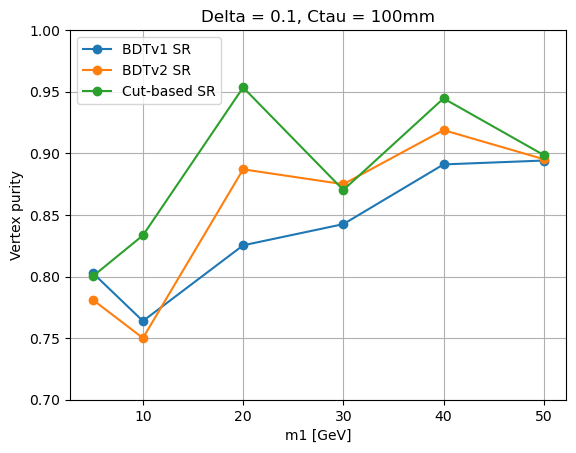

In [204]:
# ctau-100, delta 0.1

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

y_arr1 = purity['BDTv1']['0p1'].iloc[2].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[2].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[2].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 100mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 1mm')

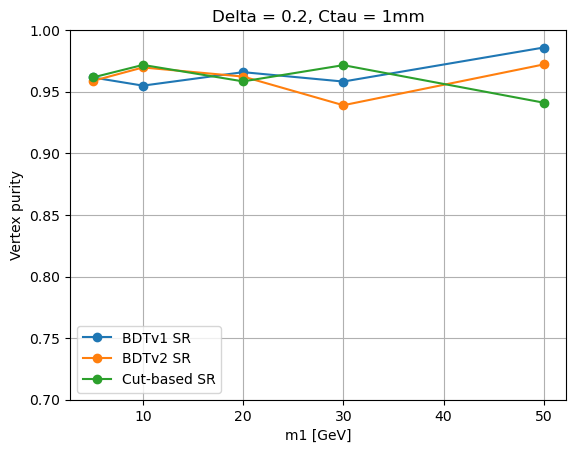

In [205]:
# ctau-1, delta 0.2

x_arr1 = [5,10,20,30,50]
x_arr2 = [5,10,20,30,50]
x_arr3 = [5,10,20,30,50]

y_arr1 = (purity['BDTv1']['0p2'].iloc[0])[purity['BDTv1']['0p2'].iloc[0] != 0].to_list()
y_arr2 = (purity['BDTv2']['0p2'].iloc[0])[purity['BDTv2']['0p2'].iloc[0] != 0].to_list()
y_arr3 = (purity['Cut']['0p2'].iloc[0])[purity['Cut']['0p2'].iloc[0] != 0].to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 1mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 10mm')

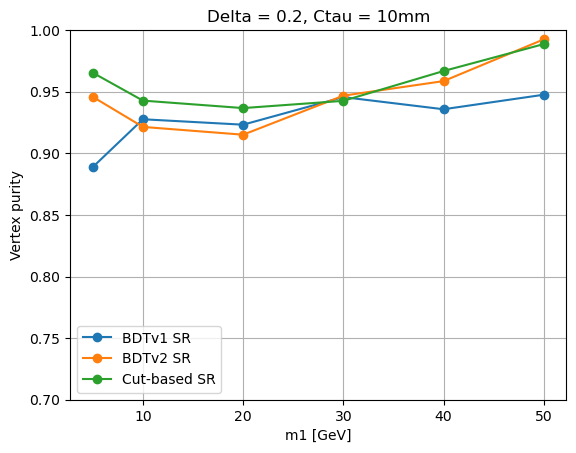

In [206]:
# ctau-10, delta 0.2

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

y_arr1 = purity['BDTv1']['0p2'].iloc[1].dropna().to_list()
y_arr2 = purity['BDTv2']['0p2'].iloc[1].dropna().to_list()
y_arr3 = purity['Cut']['0p2'].iloc[1].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 10mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 100mm')

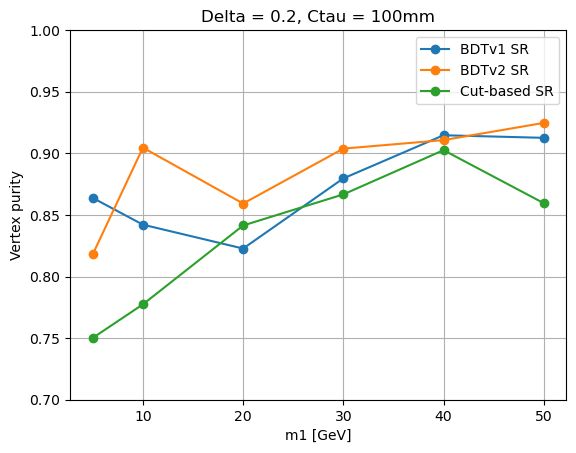

In [207]:
# ctau-100, delta 0.2

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

y_arr1 = purity['BDTv1']['0p2'].iloc[2].dropna().to_list()
y_arr2 = purity['BDTv2']['0p2'].iloc[2].dropna().to_list()
y_arr3 = purity['Cut']['0p2'].iloc[2].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 100mm')

## Compare vertex purity with other SR: only counting the ones where the gen ee are reconstructed

In [208]:
purity = {'Cut': {}, 'BDTv1': {}, 'BDTv2': {}}

for typ in s_over_b.keys():
    for delta in ['0p1','0p2']:
        with open(f'../{typ}-based-SR_Purity_delta_{delta}_hasGenEEreconstructed.csv') as x:
            ncols = len(x.readline().split(','))
        
        purity[typ][delta] = pd.read_csv(f'../{typ}-based-SR_Purity_delta_{delta}_hasGenEEreconstructed.csv', usecols=range(1,ncols))

In [209]:
purity['Cut']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,0.978,0.980,0.964,0.951,0.973,0.967
1,1.000,0.935,0.964,1.000,0.986,0.987
2,0.889,0.972,0.976,0.971,1.000,0.954


Text(0.5, 1.0, 'Delta = 0.1, Ctau = 1mm')

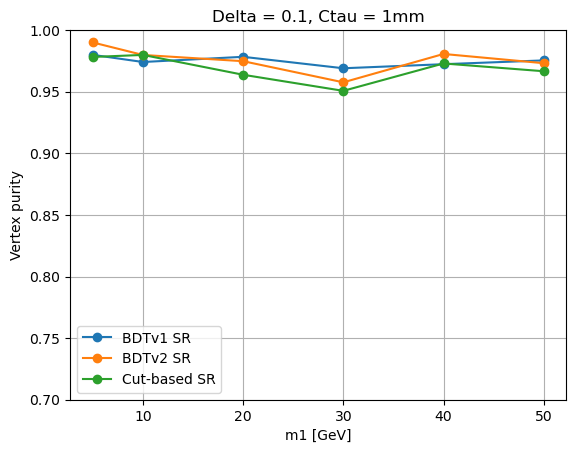

In [210]:
# ctau-1, delta 0.1

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

y_arr1 = purity['BDTv1']['0p1'].iloc[0].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[0].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[0].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 1mm')

Text(0.5, 1.0, 'Delta = 0.1, Ctau = 10mm')

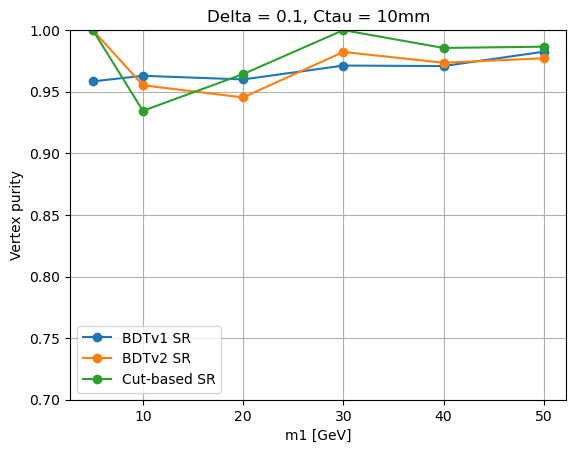

In [211]:
# ctau-10, delta 0.1

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

y_arr1 = purity['BDTv1']['0p1'].iloc[1].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[1].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[1].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 10mm')

Text(0.5, 1.0, 'Delta = 0.1, Ctau = 100mm')

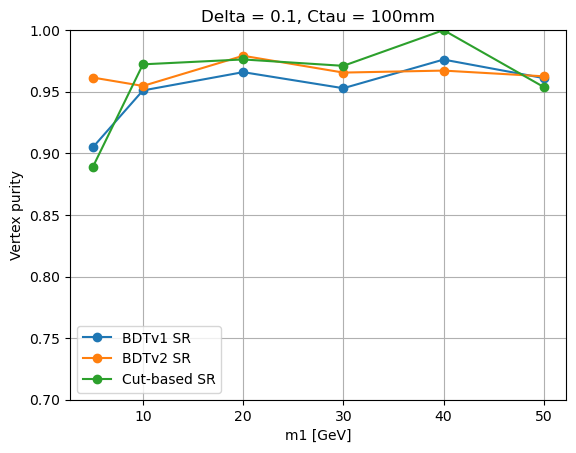

In [212]:
# ctau-100, delta 0.1

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

y_arr1 = purity['BDTv1']['0p1'].iloc[2].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[2].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[2].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 100mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 1mm')

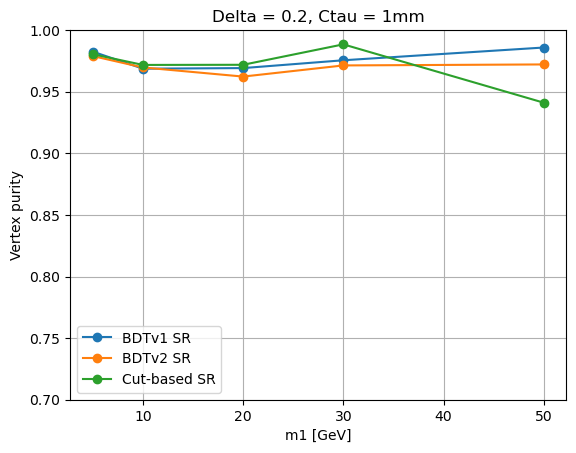

In [213]:
# ctau-1, delta 0.2

x_arr1 = [5,10,20,30,50]
x_arr2 = [5,10,20,30,50]
x_arr3 = [5,10,20,30,50]

y_arr1 = (purity['BDTv1']['0p2'].iloc[0])[purity['BDTv1']['0p2'].iloc[0] != 0].to_list()
y_arr2 = (purity['BDTv2']['0p2'].iloc[0])[purity['BDTv2']['0p2'].iloc[0] != 0].to_list()
y_arr3 = (purity['Cut']['0p2'].iloc[0])[purity['Cut']['0p2'].iloc[0] != 0].to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 1mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 10mm')

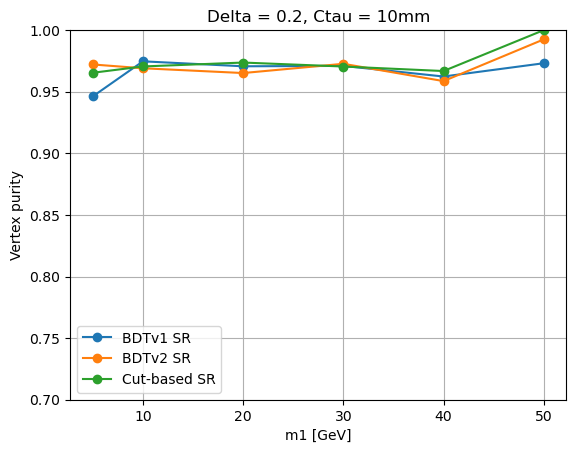

In [214]:
# ctau-10, delta 0.2

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

y_arr1 = purity['BDTv1']['0p2'].iloc[1].dropna().to_list()
y_arr2 = purity['BDTv2']['0p2'].iloc[1].dropna().to_list()
y_arr3 = purity['Cut']['0p2'].iloc[1].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 10mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 100mm')

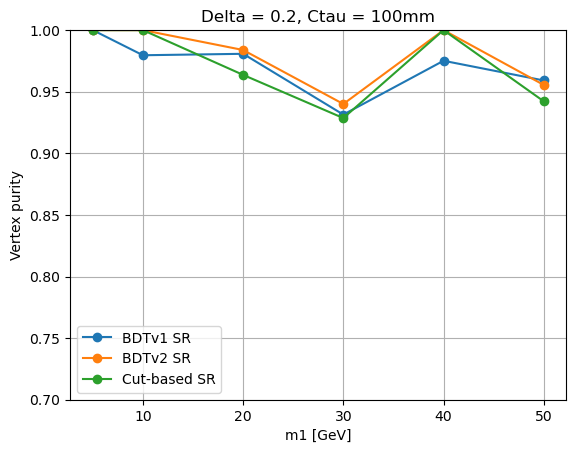

In [215]:
# ctau-100, delta 0.2

x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

y_arr1 = purity['BDTv1']['0p2'].iloc[2].dropna().to_list()
y_arr2 = purity['BDTv2']['0p2'].iloc[2].dropna().to_list()
y_arr3 = purity['Cut']['0p2'].iloc[2].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2 SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel('m1 [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.0])
plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 100mm')